<h1>Importation des bibliothèques</h1>

In [29]:
import os
import cv2
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

Vérifier la disponibilité du GPU

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print(DEVICE)

cuda


<h1>Fonctions utiles</h1>

In [49]:

def DeNormalize(img_Tensors):
    """ Permet de denormaliser une image à sa sortie du gan 
    Args:
        img_Tensors (_type_): image en tensor_

    Returns:
        _type_: image denormaliser 
    """
    return img_Tensors * 0.5 + 0.5

def show_images(images, nmax = 64):
    """ Permet d'afficher un batch sous une seule image 8x8 maxi 

    Args:
        images (_type_): images en tensor 
        nmax (int, optional): taille d'affichage . Defaults to 128.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(DeNormalize(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    """_summary_

    Args:
        dl (Dataloader): jeu de données 
        nmax (int, optional): affichage de nombre d'image . Defaults to 128.
    """
    for images, _ in dl:
        print(images.shape)
        show_images(images, nmax)
        break

def get_default_device():
    """Permet de renvoyer le type de device cuda si dispo ou bien cpu 

    Returns:
        str: cuda ou cpu
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """permet de mettre soit le modele dans le device ou les données 

    Args:
        data (données): données en entrée 
        device (str): soit cuda soit cpu 

    Returns:
        _type_: datra to device 
    """
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Permet de charger tout le jeu de données dans le device 
    """
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)


In [4]:
batch_size = 128
image_size = (256,256)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

<h1> Importation du jeu de données </h1>
pour faire de la data augmentation il faut modifier la variable transform_ds en utilisant cette <a href="https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py">doc</a>, ici dans notre cas nous avons :

-La redimension de l'image en 256x256

-Transformation en Tensor 

-Normalisation 



In [5]:
transform_ds = transforms.Compose([transforms.Resize(image_size),
#                                    transforms.RandomCrop(32, padding=2),
#                                    transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

train_ds = torchvision.datasets.ImageFolder(root="D:/artGneration/Jeu de donnees R",
                                     transform=transform_ds)
#On crée un dataloader qui permet de charger les images directement dans la mémoire avec un batch size de 128 et egalement les données seront chargée aleatoirement 
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
print(len(train_ds))

3626


Affichage des exemples, le permute permet de permuté les données de la matrice car en tensor elle sont ordonnées autrement 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


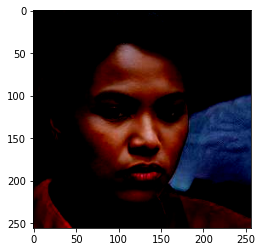

In [48]:
images,_ = train_ds[10]
print(images.size())
plt.imshow(images.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


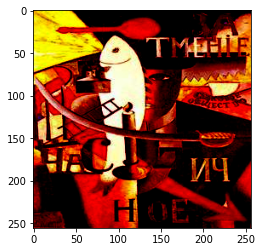

In [7]:
images,_ = train_ds[872]
plt.imshow(images.permute(1,2,0))

Exemple d'un batch

torch.Size([128, 3, 256, 256])


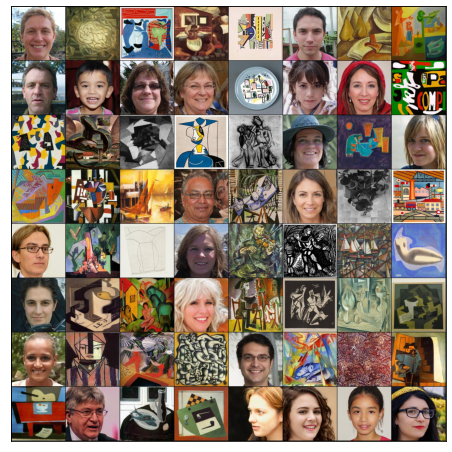

In [8]:
#affichage des 64 premier image d'un batch 
show_batch(train_dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
#mettre les données dans le gpu 
train_dl = DeviceDataLoader(train_dl, device)

<h1>Creation de l'architecture du discriminateur et generateur</h1>

In [12]:
discriminator = nn.Sequential(
    # in: 3 x 256 x 256 sous forme channel x height x width 

    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 128 x 128

    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
latent_size = 128

In [15]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1 vecteur de bruit en entrée 

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 64 x 128 x 128

    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 256 x 256 sortie sous forme de channels x height x width 
)

Mettre les deux réseaux dans le GPU 

In [ ]:
discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

Exemple d'une génération en créant un vecteur de bruit normalisé en utilisant randn

torch.Size([128, 3, 256, 256])


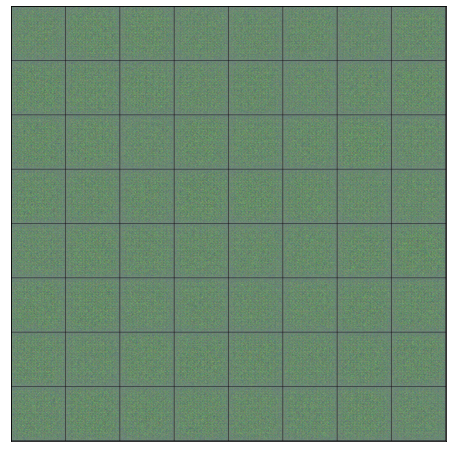

In [16]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

<h1>Entrainement de nos deux modèles générateur et discriminateur</h1>

In [50]:
#direction pour sauvgarder les images de chaque epoque
sample_dir = 'D:/artGneration/Samples'
#creation d'un vecteur de bruit suivant une lois normal 
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [18]:
def train_discriminator(real_images, opt_d):
    """fonction qui permet d'entrainer le modele discriminateur 

    Args:
        real_images (_type_): les images reel 
        opt_d (_type_): choix d'un optimiser 

    Returns:
        _type_: loss pour le generateur , score reel et score fake 
    """
    # initialiser le gradient 
    opt_d.zero_grad()

    # passer les images reelles dans le discriminateur 
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # generation des images fausses 
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Passer les images fake générées par le generateur dans le discriminateur 
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # mise a jour des poids du descriminateur 
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()

    #renvoiyer la loss pour qu'elle soit utiliser par le generateur 
    return loss.item(), real_score, fake_score

def train_generator(opt_g):
    """ cette fonction permet d'entrainer le generateur 

    Args:
        opt_g (_type_): choisir un optimiser 

    Returns:
        _type_: la loss 
    """
    # initialiser le gradient 
    opt_g.zero_grad()
    
    # generer les images fake 
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # passer l'image dans le discriminateur pour voir le resultat 
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # mise à jour du generateur 
    loss.backward()
    opt_g.step()
    
    return loss.item()

def trainGAN(epochs, lr, start_idx=1):
    """cette fonction est la fonction principale qui permet de faire l'enrainement des deux reseaux 

    Args:
        epochs (int): nombre d'epoque d'entrainement 
        lr (float): learning rate 
        start_idx (int, optional): utiliser juste pour l'affichage si on veux reentrainer le modele  . Defaults to 1.

    Returns:
        _type_: les loss et les scores 
    """
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Creation des optiomiseur 
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    #boucle d'entrainement 
    for epoch in range(epochs):

        if epoch == 100:
          for g in opt_d.param_groups:
            g['lr'] = 0.0001

        if epoch == 100:
          for gr in opt_g.param_groups:
            gr['lr'] = 0.0001

        for real_images, _ in tqdm(train_dl):
            # entrainement du discriminateur 
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # entrainement du generateur 
            loss_g = train_generator(opt_g)
            
        # sauvgarder les loss et les scores 
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # affichage de l'avancement de l'entrainement 
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # auvgarder les images generées pour chaque époque 
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(DeNormalize(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [25]:
lr = 0.001
epochs = 1000

In [30]:
history = trainGAN(epochs,lr)

100%|██████████| 29/29 [01:31<00:00,  3.16s/it]


Epoch [1/1000], loss_g: 2.4093, loss_d: 0.8633, real_score: 0.7608, fake_score: 0.3829
Saving generated-images-0001.png


100%|██████████| 29/29 [01:17<00:00,  2.67s/it]


Epoch [2/1000], loss_g: 3.5451, loss_d: 0.6663, real_score: 0.8856, fake_score: 0.2885
Saving generated-images-0002.png


100%|██████████| 29/29 [01:26<00:00,  2.97s/it]


Epoch [3/1000], loss_g: 4.2758, loss_d: 0.1309, real_score: 0.9424, fake_score: 0.0325
Saving generated-images-0003.png


100%|██████████| 29/29 [01:22<00:00,  2.84s/it]


Epoch [4/1000], loss_g: 2.6227, loss_d: 0.7974, real_score: 0.6044, fake_score: 0.0587
Saving generated-images-0004.png


100%|██████████| 29/29 [01:17<00:00,  2.67s/it]


Epoch [5/1000], loss_g: 5.8757, loss_d: 0.4748, real_score: 0.9641, fake_score: 0.2826
Saving generated-images-0005.png


100%|██████████| 29/29 [01:27<00:00,  3.01s/it]


Epoch [6/1000], loss_g: 6.1727, loss_d: 0.1427, real_score: 0.9758, fake_score: 0.1080
Saving generated-images-0006.png


100%|██████████| 29/29 [01:19<00:00,  2.73s/it]


Epoch [7/1000], loss_g: 4.5219, loss_d: 0.1725, real_score: 0.9485, fake_score: 0.0844
Saving generated-images-0007.png


100%|██████████| 29/29 [01:16<00:00,  2.63s/it]


Epoch [8/1000], loss_g: 8.3760, loss_d: 0.6071, real_score: 0.9432, fake_score: 0.3166
Saving generated-images-0008.png


100%|██████████| 29/29 [01:14<00:00,  2.55s/it]


Epoch [9/1000], loss_g: 6.2869, loss_d: 0.6089, real_score: 0.9537, fake_score: 0.2369
Saving generated-images-0009.png


100%|██████████| 29/29 [01:14<00:00,  2.58s/it]


Epoch [10/1000], loss_g: 7.3275, loss_d: 1.9633, real_score: 0.8131, fake_score: 0.5544
Saving generated-images-0010.png


100%|██████████| 29/29 [01:18<00:00,  2.71s/it]


Epoch [11/1000], loss_g: 2.0302, loss_d: 1.6888, real_score: 0.5464, fake_score: 0.4216
Saving generated-images-0011.png


100%|██████████| 29/29 [01:21<00:00,  2.83s/it]


Epoch [12/1000], loss_g: 4.5009, loss_d: 1.8251, real_score: 0.3040, fake_score: 0.0147
Saving generated-images-0012.png


100%|██████████| 29/29 [01:17<00:00,  2.68s/it]


Epoch [13/1000], loss_g: 14.4921, loss_d: 2.4739, real_score: 0.9853, fake_score: 0.8425
Saving generated-images-0013.png


100%|██████████| 29/29 [01:13<00:00,  2.55s/it]


Epoch [14/1000], loss_g: 5.6326, loss_d: 1.5957, real_score: 0.8754, fake_score: 0.6657
Saving generated-images-0014.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [15/1000], loss_g: 4.5637, loss_d: 1.4808, real_score: 0.9141, fake_score: 0.6627
Saving generated-images-0015.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [16/1000], loss_g: 1.8094, loss_d: 2.1127, real_score: 0.2061, fake_score: 0.0164
Saving generated-images-0016.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [17/1000], loss_g: 4.8358, loss_d: 0.5080, real_score: 0.9173, fake_score: 0.3148
Saving generated-images-0017.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [18/1000], loss_g: 2.6858, loss_d: 1.4935, real_score: 0.7218, fake_score: 0.5925
Saving generated-images-0018.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [19/1000], loss_g: 3.3218, loss_d: 1.2094, real_score: 0.7674, fake_score: 0.4558
Saving generated-images-0019.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [20/1000], loss_g: 2.5837, loss_d: 0.8368, real_score: 0.7213, fake_score: 0.3529
Saving generated-images-0020.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [21/1000], loss_g: 2.9676, loss_d: 1.1474, real_score: 0.7327, fake_score: 0.4881
Saving generated-images-0021.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [22/1000], loss_g: 1.7613, loss_d: 1.6980, real_score: 0.8572, fake_score: 0.7166
Saving generated-images-0022.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [23/1000], loss_g: 1.6909, loss_d: 0.9855, real_score: 0.5957, fake_score: 0.2815
Saving generated-images-0023.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [24/1000], loss_g: 1.7671, loss_d: 1.1405, real_score: 0.4368, fake_score: 0.1018
Saving generated-images-0024.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [25/1000], loss_g: 3.6463, loss_d: 1.1787, real_score: 0.7363, fake_score: 0.4889
Saving generated-images-0025.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [26/1000], loss_g: 3.1279, loss_d: 1.4035, real_score: 0.7177, fake_score: 0.5371
Saving generated-images-0026.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [27/1000], loss_g: 2.2375, loss_d: 0.9648, real_score: 0.5996, fake_score: 0.0992
Saving generated-images-0027.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [28/1000], loss_g: 1.3576, loss_d: 1.0665, real_score: 0.4693, fake_score: 0.1586
Saving generated-images-0028.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [29/1000], loss_g: 1.9622, loss_d: 0.7623, real_score: 0.7172, fake_score: 0.2574
Saving generated-images-0029.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [30/1000], loss_g: 1.6611, loss_d: 1.0019, real_score: 0.5139, fake_score: 0.1135
Saving generated-images-0030.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [31/1000], loss_g: 1.5295, loss_d: 1.3104, real_score: 0.3843, fake_score: 0.1285
Saving generated-images-0031.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [32/1000], loss_g: 1.7176, loss_d: 1.2929, real_score: 0.5277, fake_score: 0.3496
Saving generated-images-0032.png


100%|██████████| 29/29 [01:11<00:00,  2.47s/it]


Epoch [33/1000], loss_g: 2.8305, loss_d: 0.8109, real_score: 0.6965, fake_score: 0.3145
Saving generated-images-0033.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [34/1000], loss_g: 1.6454, loss_d: 0.8408, real_score: 0.5924, fake_score: 0.1907
Saving generated-images-0034.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [35/1000], loss_g: 1.1001, loss_d: 1.0622, real_score: 0.6396, fake_score: 0.3725
Saving generated-images-0035.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [36/1000], loss_g: 1.5330, loss_d: 1.2957, real_score: 0.4335, fake_score: 0.2947
Saving generated-images-0036.png


100%|██████████| 29/29 [01:10<00:00,  2.44s/it]


Epoch [37/1000], loss_g: 1.7636, loss_d: 0.9212, real_score: 0.6658, fake_score: 0.3379
Saving generated-images-0037.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [38/1000], loss_g: 0.4584, loss_d: 1.9098, real_score: 0.2711, fake_score: 0.2032
Saving generated-images-0038.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [39/1000], loss_g: 2.3352, loss_d: 0.7430, real_score: 0.6417, fake_score: 0.2108
Saving generated-images-0039.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [40/1000], loss_g: 2.9549, loss_d: 0.9946, real_score: 0.7893, fake_score: 0.4954
Saving generated-images-0040.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [41/1000], loss_g: 1.0002, loss_d: 1.7141, real_score: 0.2763, fake_score: 0.1227
Saving generated-images-0041.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [42/1000], loss_g: 1.9339, loss_d: 0.9285, real_score: 0.5422, fake_score: 0.1487
Saving generated-images-0042.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [43/1000], loss_g: 1.6086, loss_d: 1.1997, real_score: 0.6533, fake_score: 0.4667
Saving generated-images-0043.png


100%|██████████| 29/29 [01:11<00:00,  2.47s/it]


Epoch [44/1000], loss_g: 1.3173, loss_d: 0.9449, real_score: 0.6581, fake_score: 0.3394
Saving generated-images-0044.png


100%|██████████| 29/29 [01:28<00:00,  3.07s/it]


Epoch [45/1000], loss_g: 1.7316, loss_d: 0.8398, real_score: 0.8649, fake_score: 0.4458
Saving generated-images-0045.png


100%|██████████| 29/29 [01:21<00:00,  2.80s/it]


Epoch [46/1000], loss_g: 4.7757, loss_d: 1.3862, real_score: 0.8502, fake_score: 0.6574
Saving generated-images-0046.png


100%|██████████| 29/29 [01:10<00:00,  2.44s/it]


Epoch [47/1000], loss_g: 1.6455, loss_d: 0.8040, real_score: 0.5997, fake_score: 0.1877
Saving generated-images-0047.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [48/1000], loss_g: 0.9991, loss_d: 1.1046, real_score: 0.4815, fake_score: 0.2510
Saving generated-images-0048.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [49/1000], loss_g: 2.5721, loss_d: 1.1737, real_score: 0.6635, fake_score: 0.4427
Saving generated-images-0049.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [50/1000], loss_g: 2.1376, loss_d: 1.0588, real_score: 0.6105, fake_score: 0.3278
Saving generated-images-0050.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [51/1000], loss_g: 2.4623, loss_d: 0.6311, real_score: 0.6988, fake_score: 0.1896
Saving generated-images-0051.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [52/1000], loss_g: 3.0634, loss_d: 0.7838, real_score: 0.6999, fake_score: 0.2967
Saving generated-images-0052.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [53/1000], loss_g: 2.8313, loss_d: 0.7164, real_score: 0.6684, fake_score: 0.2194
Saving generated-images-0053.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [54/1000], loss_g: 5.6743, loss_d: 0.3541, real_score: 0.9459, fake_score: 0.2263
Saving generated-images-0054.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [55/1000], loss_g: 2.8074, loss_d: 1.6231, real_score: 0.2573, fake_score: 0.0099
Saving generated-images-0055.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [56/1000], loss_g: 1.8591, loss_d: 2.3677, real_score: 0.1681, fake_score: 0.1118
Saving generated-images-0056.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [57/1000], loss_g: 4.5719, loss_d: 1.3295, real_score: 0.8115, fake_score: 0.5879
Saving generated-images-0057.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [58/1000], loss_g: 2.3440, loss_d: 0.6923, real_score: 0.6330, fake_score: 0.1420
Saving generated-images-0058.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [59/1000], loss_g: 1.5178, loss_d: 0.5393, real_score: 0.8786, fake_score: 0.3072
Saving generated-images-0059.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [60/1000], loss_g: 4.5652, loss_d: 0.1992, real_score: 0.9657, fake_score: 0.1382
Saving generated-images-0060.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [61/1000], loss_g: 4.5492, loss_d: 0.8630, real_score: 0.8643, fake_score: 0.4599
Saving generated-images-0061.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [62/1000], loss_g: 1.0216, loss_d: 1.0284, real_score: 0.4436, fake_score: 0.0850
Saving generated-images-0062.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [63/1000], loss_g: 3.0336, loss_d: 0.6025, real_score: 0.6698, fake_score: 0.1228
Saving generated-images-0063.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [64/1000], loss_g: 2.7536, loss_d: 0.8875, real_score: 0.6716, fake_score: 0.3435
Saving generated-images-0064.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [65/1000], loss_g: 2.7469, loss_d: 0.5054, real_score: 0.8002, fake_score: 0.2178
Saving generated-images-0065.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [66/1000], loss_g: 7.2989, loss_d: 1.6647, real_score: 0.7709, fake_score: 0.7133
Saving generated-images-0066.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [67/1000], loss_g: 4.5727, loss_d: 0.5624, real_score: 0.9423, fake_score: 0.3635
Saving generated-images-0067.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [68/1000], loss_g: 4.6278, loss_d: 1.0211, real_score: 0.7601, fake_score: 0.4770
Saving generated-images-0068.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [69/1000], loss_g: 2.4246, loss_d: 1.2970, real_score: 0.8581, fake_score: 0.5734
Saving generated-images-0069.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [70/1000], loss_g: 2.2953, loss_d: 0.8080, real_score: 0.7399, fake_score: 0.3496
Saving generated-images-0070.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [71/1000], loss_g: 2.3946, loss_d: 0.6918, real_score: 0.6423, fake_score: 0.1688
Saving generated-images-0071.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [72/1000], loss_g: 3.7359, loss_d: 0.7179, real_score: 0.7664, fake_score: 0.2966
Saving generated-images-0072.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [73/1000], loss_g: 4.2432, loss_d: 0.8964, real_score: 0.7897, fake_score: 0.4077
Saving generated-images-0073.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [74/1000], loss_g: 3.8085, loss_d: 1.5980, real_score: 0.9353, fake_score: 0.7125
Saving generated-images-0074.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [75/1000], loss_g: 2.8020, loss_d: 0.8467, real_score: 0.5934, fake_score: 0.2090
Saving generated-images-0075.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [76/1000], loss_g: 3.5070, loss_d: 0.9382, real_score: 0.9407, fake_score: 0.5296
Saving generated-images-0076.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [77/1000], loss_g: 2.5967, loss_d: 0.9246, real_score: 0.7683, fake_score: 0.4256
Saving generated-images-0077.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [78/1000], loss_g: 1.2581, loss_d: 1.2534, real_score: 0.5328, fake_score: 0.3310
Saving generated-images-0078.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [79/1000], loss_g: 2.1491, loss_d: 0.9842, real_score: 0.5327, fake_score: 0.1944
Saving generated-images-0079.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [80/1000], loss_g: 3.0031, loss_d: 1.3349, real_score: 0.6462, fake_score: 0.3768
Saving generated-images-0080.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [81/1000], loss_g: 3.3382, loss_d: 0.6536, real_score: 0.7280, fake_score: 0.2208
Saving generated-images-0081.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [82/1000], loss_g: 4.0585, loss_d: 0.7777, real_score: 0.9499, fake_score: 0.4764
Saving generated-images-0082.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [83/1000], loss_g: 3.4306, loss_d: 0.8166, real_score: 0.7373, fake_score: 0.3364
Saving generated-images-0083.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [84/1000], loss_g: 3.1238, loss_d: 1.3522, real_score: 0.6909, fake_score: 0.5440
Saving generated-images-0084.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [85/1000], loss_g: 1.9319, loss_d: 0.9844, real_score: 0.4780, fake_score: 0.0875
Saving generated-images-0085.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [86/1000], loss_g: 2.2113, loss_d: 1.0235, real_score: 0.4845, fake_score: 0.0915
Saving generated-images-0086.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [87/1000], loss_g: 2.5581, loss_d: 1.2891, real_score: 0.3658, fake_score: 0.0596
Saving generated-images-0087.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [88/1000], loss_g: 5.1870, loss_d: 0.3442, real_score: 0.9409, fake_score: 0.2275
Saving generated-images-0088.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [89/1000], loss_g: 6.9706, loss_d: 0.8799, real_score: 0.9234, fake_score: 0.4818
Saving generated-images-0089.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [90/1000], loss_g: 5.1830, loss_d: 0.6468, real_score: 0.9263, fake_score: 0.3593
Saving generated-images-0090.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [91/1000], loss_g: 3.8191, loss_d: 0.6763, real_score: 0.8037, fake_score: 0.3227
Saving generated-images-0091.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [92/1000], loss_g: 1.2092, loss_d: 0.8424, real_score: 0.5698, fake_score: 0.1227
Saving generated-images-0092.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [93/1000], loss_g: 6.4733, loss_d: 0.9550, real_score: 0.8728, fake_score: 0.4759
Saving generated-images-0093.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [94/1000], loss_g: 3.3691, loss_d: 0.1906, real_score: 0.8608, fake_score: 0.0258
Saving generated-images-0094.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [95/1000], loss_g: 4.5010, loss_d: 0.3876, real_score: 0.8677, fake_score: 0.1964
Saving generated-images-0095.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [96/1000], loss_g: 5.9634, loss_d: 1.0349, real_score: 0.9611, fake_score: 0.5517
Saving generated-images-0096.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [97/1000], loss_g: 3.7923, loss_d: 1.2951, real_score: 0.3864, fake_score: 0.0435
Saving generated-images-0097.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [98/1000], loss_g: 2.6576, loss_d: 1.3929, real_score: 0.9509, fake_score: 0.6578
Saving generated-images-0098.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [99/1000], loss_g: 3.0483, loss_d: 0.6127, real_score: 0.7311, fake_score: 0.1823
Saving generated-images-0099.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [100/1000], loss_g: 3.8067, loss_d: 0.9593, real_score: 0.7708, fake_score: 0.3625
Saving generated-images-0100.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [101/1000], loss_g: 1.6952, loss_d: 0.6554, real_score: 0.7772, fake_score: 0.2935
Saving generated-images-0101.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [102/1000], loss_g: 1.8808, loss_d: 0.6454, real_score: 0.7375, fake_score: 0.2483
Saving generated-images-0102.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [103/1000], loss_g: 2.7555, loss_d: 0.4552, real_score: 0.8253, fake_score: 0.2005
Saving generated-images-0103.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [104/1000], loss_g: 2.0376, loss_d: 0.6789, real_score: 0.7489, fake_score: 0.2625
Saving generated-images-0104.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [105/1000], loss_g: 2.3067, loss_d: 0.5254, real_score: 0.8344, fake_score: 0.2704
Saving generated-images-0105.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [106/1000], loss_g: 2.1869, loss_d: 0.4170, real_score: 0.8764, fake_score: 0.2234
Saving generated-images-0106.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [107/1000], loss_g: 1.5855, loss_d: 0.5245, real_score: 0.7843, fake_score: 0.2099
Saving generated-images-0107.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [108/1000], loss_g: 2.1333, loss_d: 0.5424, real_score: 0.7056, fake_score: 0.1295
Saving generated-images-0108.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [109/1000], loss_g: 2.2780, loss_d: 0.4917, real_score: 0.8165, fake_score: 0.2275
Saving generated-images-0109.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [110/1000], loss_g: 2.2530, loss_d: 0.6705, real_score: 0.7187, fake_score: 0.2284
Saving generated-images-0110.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [111/1000], loss_g: 1.9224, loss_d: 0.5583, real_score: 0.7645, fake_score: 0.2186
Saving generated-images-0111.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [112/1000], loss_g: 2.3373, loss_d: 0.5126, real_score: 0.8653, fake_score: 0.2839
Saving generated-images-0112.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [113/1000], loss_g: 2.8473, loss_d: 0.4292, real_score: 0.7559, fake_score: 0.0852
Saving generated-images-0113.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [114/1000], loss_g: 2.6395, loss_d: 0.4394, real_score: 0.8777, fake_score: 0.2428
Saving generated-images-0114.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [115/1000], loss_g: 1.1367, loss_d: 1.1171, real_score: 0.4887, fake_score: 0.1664
Saving generated-images-0115.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [116/1000], loss_g: 1.9194, loss_d: 0.4948, real_score: 0.7097, fake_score: 0.0990
Saving generated-images-0116.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [117/1000], loss_g: 1.6261, loss_d: 0.6176, real_score: 0.7008, fake_score: 0.1444
Saving generated-images-0117.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [118/1000], loss_g: 2.6922, loss_d: 0.3292, real_score: 0.9139, fake_score: 0.1957
Saving generated-images-0118.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [119/1000], loss_g: 2.8103, loss_d: 0.4266, real_score: 0.8295, fake_score: 0.1831
Saving generated-images-0119.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [120/1000], loss_g: 3.7727, loss_d: 0.3815, real_score: 0.9232, fake_score: 0.2393
Saving generated-images-0120.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [121/1000], loss_g: 2.6120, loss_d: 0.9193, real_score: 0.5238, fake_score: 0.0557
Saving generated-images-0121.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [122/1000], loss_g: 2.7370, loss_d: 0.4759, real_score: 0.7764, fake_score: 0.1360
Saving generated-images-0122.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [123/1000], loss_g: 2.6223, loss_d: 0.6471, real_score: 0.7217, fake_score: 0.2201
Saving generated-images-0123.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [124/1000], loss_g: 3.2983, loss_d: 0.3831, real_score: 0.8931, fake_score: 0.2096
Saving generated-images-0124.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [125/1000], loss_g: 2.9872, loss_d: 0.3248, real_score: 0.8335, fake_score: 0.1058
Saving generated-images-0125.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [126/1000], loss_g: 3.2468, loss_d: 0.2529, real_score: 0.9091, fake_score: 0.1370
Saving generated-images-0126.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [127/1000], loss_g: 3.2135, loss_d: 0.3713, real_score: 0.9560, fake_score: 0.2563
Saving generated-images-0127.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [128/1000], loss_g: 2.8935, loss_d: 0.2592, real_score: 0.9187, fake_score: 0.1392
Saving generated-images-0128.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [129/1000], loss_g: 3.4679, loss_d: 0.2643, real_score: 0.8700, fake_score: 0.1004
Saving generated-images-0129.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [130/1000], loss_g: 2.1818, loss_d: 0.4501, real_score: 0.7200, fake_score: 0.0579
Saving generated-images-0130.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [131/1000], loss_g: 3.3236, loss_d: 0.3326, real_score: 0.9391, fake_score: 0.2175
Saving generated-images-0131.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [132/1000], loss_g: 5.0292, loss_d: 0.3399, real_score: 0.9801, fake_score: 0.2470
Saving generated-images-0132.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [133/1000], loss_g: 3.3852, loss_d: 0.2287, real_score: 0.9291, fake_score: 0.1301
Saving generated-images-0133.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [134/1000], loss_g: 2.2956, loss_d: 0.4680, real_score: 0.7758, fake_score: 0.1304
Saving generated-images-0134.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [135/1000], loss_g: 3.1904, loss_d: 0.2366, real_score: 0.8820, fake_score: 0.0876
Saving generated-images-0135.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [136/1000], loss_g: 2.8156, loss_d: 0.2666, real_score: 0.9335, fake_score: 0.1558
Saving generated-images-0136.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [137/1000], loss_g: 3.0431, loss_d: 0.3309, real_score: 0.7891, fake_score: 0.0525
Saving generated-images-0137.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [138/1000], loss_g: 3.2657, loss_d: 0.9871, real_score: 0.5381, fake_score: 0.0235
Saving generated-images-0138.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [139/1000], loss_g: 1.9572, loss_d: 0.5005, real_score: 0.7509, fake_score: 0.0742
Saving generated-images-0139.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [140/1000], loss_g: 4.5680, loss_d: 0.2135, real_score: 0.8875, fake_score: 0.0636
Saving generated-images-0140.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [141/1000], loss_g: 3.3380, loss_d: 0.5316, real_score: 0.7930, fake_score: 0.2076
Saving generated-images-0141.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [142/1000], loss_g: 2.5684, loss_d: 0.3949, real_score: 0.7767, fake_score: 0.0793
Saving generated-images-0142.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [143/1000], loss_g: 3.3912, loss_d: 0.4109, real_score: 0.8182, fake_score: 0.1213
Saving generated-images-0143.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [144/1000], loss_g: 2.3478, loss_d: 0.5332, real_score: 0.7506, fake_score: 0.1372
Saving generated-images-0144.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [145/1000], loss_g: 4.7066, loss_d: 0.2785, real_score: 0.9306, fake_score: 0.1728
Saving generated-images-0145.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [146/1000], loss_g: 2.5055, loss_d: 0.4752, real_score: 0.7586, fake_score: 0.1096
Saving generated-images-0146.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [147/1000], loss_g: 5.2823, loss_d: 0.5471, real_score: 0.9777, fake_score: 0.3481
Saving generated-images-0147.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [148/1000], loss_g: 2.4731, loss_d: 0.3953, real_score: 0.7907, fake_score: 0.0907
Saving generated-images-0148.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [149/1000], loss_g: 3.6785, loss_d: 0.2107, real_score: 0.8758, fake_score: 0.0415
Saving generated-images-0149.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [150/1000], loss_g: 4.2144, loss_d: 0.2012, real_score: 0.9260, fake_score: 0.0972
Saving generated-images-0150.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [151/1000], loss_g: 4.1099, loss_d: 0.2490, real_score: 0.8583, fake_score: 0.0533
Saving generated-images-0151.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [152/1000], loss_g: 5.5320, loss_d: 0.2902, real_score: 0.9442, fake_score: 0.1761
Saving generated-images-0152.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [153/1000], loss_g: 4.3330, loss_d: 0.2389, real_score: 0.9067, fake_score: 0.1101
Saving generated-images-0153.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [154/1000], loss_g: 4.7370, loss_d: 0.2362, real_score: 0.9895, fake_score: 0.1838
Saving generated-images-0154.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [155/1000], loss_g: 2.6821, loss_d: 0.1952, real_score: 0.8879, fake_score: 0.0489
Saving generated-images-0155.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [156/1000], loss_g: 2.7790, loss_d: 0.2781, real_score: 0.8517, fake_score: 0.0627
Saving generated-images-0156.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [157/1000], loss_g: 4.1473, loss_d: 0.1434, real_score: 0.9593, fake_score: 0.0883
Saving generated-images-0157.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [158/1000], loss_g: 3.1807, loss_d: 0.2291, real_score: 0.8892, fake_score: 0.0673
Saving generated-images-0158.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [159/1000], loss_g: 3.5913, loss_d: 0.4368, real_score: 0.7030, fake_score: 0.0123
Saving generated-images-0159.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [160/1000], loss_g: 4.2626, loss_d: 0.0813, real_score: 0.9688, fake_score: 0.0434
Saving generated-images-0160.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [161/1000], loss_g: 4.1497, loss_d: 0.2963, real_score: 0.7915, fake_score: 0.0099
Saving generated-images-0161.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [162/1000], loss_g: 5.1514, loss_d: 0.3014, real_score: 0.9820, fake_score: 0.2256
Saving generated-images-0162.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [163/1000], loss_g: 5.3427, loss_d: 0.3215, real_score: 0.9838, fake_score: 0.2304
Saving generated-images-0163.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [164/1000], loss_g: 4.3479, loss_d: 0.0559, real_score: 0.9951, fake_score: 0.0457
Saving generated-images-0164.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [165/1000], loss_g: 5.2855, loss_d: 0.0629, real_score: 0.9582, fake_score: 0.0131
Saving generated-images-0165.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [166/1000], loss_g: 0.8360, loss_d: 0.6524, real_score: 0.6277, fake_score: 0.0193
Saving generated-images-0166.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [167/1000], loss_g: 4.6315, loss_d: 0.2863, real_score: 0.8367, fake_score: 0.0339
Saving generated-images-0167.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [168/1000], loss_g: 4.7962, loss_d: 0.0827, real_score: 0.9728, fake_score: 0.0504
Saving generated-images-0168.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [169/1000], loss_g: 5.1120, loss_d: 0.1112, real_score: 0.9699, fake_score: 0.0688
Saving generated-images-0169.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [170/1000], loss_g: 6.8504, loss_d: 0.2979, real_score: 0.9922, fake_score: 0.2211
Saving generated-images-0170.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [171/1000], loss_g: 4.0471, loss_d: 0.2452, real_score: 0.8192, fake_score: 0.0067
Saving generated-images-0171.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [172/1000], loss_g: 3.5208, loss_d: 0.4772, real_score: 0.7673, fake_score: 0.0649
Saving generated-images-0172.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [173/1000], loss_g: 4.1860, loss_d: 0.1999, real_score: 0.9394, fake_score: 0.1029
Saving generated-images-0173.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [174/1000], loss_g: 3.8956, loss_d: 0.2739, real_score: 0.8520, fake_score: 0.0459
Saving generated-images-0174.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [175/1000], loss_g: 5.9945, loss_d: 0.1724, real_score: 0.9586, fake_score: 0.1063
Saving generated-images-0175.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [176/1000], loss_g: 4.7304, loss_d: 0.1999, real_score: 0.9763, fake_score: 0.1487
Saving generated-images-0176.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [177/1000], loss_g: 6.2286, loss_d: 0.4090, real_score: 0.9744, fake_score: 0.2634
Saving generated-images-0177.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [178/1000], loss_g: 5.2599, loss_d: 0.3985, real_score: 0.9113, fake_score: 0.1998
Saving generated-images-0178.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [179/1000], loss_g: 4.0278, loss_d: 0.3485, real_score: 0.8211, fake_score: 0.1007
Saving generated-images-0179.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [180/1000], loss_g: 2.6388, loss_d: 0.5244, real_score: 0.7250, fake_score: 0.1029
Saving generated-images-0180.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [181/1000], loss_g: 3.5486, loss_d: 0.4807, real_score: 0.6952, fake_score: 0.0114
Saving generated-images-0181.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [182/1000], loss_g: 6.0787, loss_d: 0.1028, real_score: 0.9399, fake_score: 0.0358
Saving generated-images-0182.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [183/1000], loss_g: 5.0043, loss_d: 0.1341, real_score: 0.9699, fake_score: 0.0890
Saving generated-images-0183.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [184/1000], loss_g: 4.4826, loss_d: 0.0466, real_score: 0.9700, fake_score: 0.0152
Saving generated-images-0184.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [185/1000], loss_g: 7.0986, loss_d: 0.5342, real_score: 0.9632, fake_score: 0.3047
Saving generated-images-0185.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [186/1000], loss_g: 4.9136, loss_d: 0.2599, real_score: 0.9051, fake_score: 0.1319
Saving generated-images-0186.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [187/1000], loss_g: 4.5093, loss_d: 0.1299, real_score: 0.9560, fake_score: 0.0741
Saving generated-images-0187.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [188/1000], loss_g: 5.6121, loss_d: 0.2275, real_score: 0.9498, fake_score: 0.1360
Saving generated-images-0188.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [189/1000], loss_g: 4.9930, loss_d: 0.0877, real_score: 0.9463, fake_score: 0.0265
Saving generated-images-0189.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [190/1000], loss_g: 4.0852, loss_d: 0.3860, real_score: 0.7656, fake_score: 0.0057
Saving generated-images-0190.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [191/1000], loss_g: 4.5630, loss_d: 0.1454, real_score: 0.9537, fake_score: 0.0837
Saving generated-images-0191.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [192/1000], loss_g: 2.8887, loss_d: 0.3141, real_score: 0.8323, fake_score: 0.0724
Saving generated-images-0192.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [193/1000], loss_g: 4.7259, loss_d: 0.2998, real_score: 0.8774, fake_score: 0.1175
Saving generated-images-0193.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [194/1000], loss_g: 4.3364, loss_d: 0.1600, real_score: 0.9671, fake_score: 0.1073
Saving generated-images-0194.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [195/1000], loss_g: 5.3888, loss_d: 0.1386, real_score: 0.9261, fake_score: 0.0487
Saving generated-images-0195.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [196/1000], loss_g: 4.4708, loss_d: 0.0606, real_score: 0.9790, fake_score: 0.0364
Saving generated-images-0196.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [197/1000], loss_g: 3.3158, loss_d: 0.2870, real_score: 0.8293, fake_score: 0.0606
Saving generated-images-0197.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [198/1000], loss_g: 6.4591, loss_d: 0.3226, real_score: 0.9707, fake_score: 0.2072
Saving generated-images-0198.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [199/1000], loss_g: 5.8546, loss_d: 0.0334, real_score: 0.9820, fake_score: 0.0142
Saving generated-images-0199.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [200/1000], loss_g: 4.5661, loss_d: 0.1948, real_score: 0.9349, fake_score: 0.0951
Saving generated-images-0200.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [201/1000], loss_g: 3.0254, loss_d: 0.4041, real_score: 0.7768, fake_score: 0.0569
Saving generated-images-0201.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [202/1000], loss_g: 3.9643, loss_d: 0.1898, real_score: 0.8946, fake_score: 0.0426
Saving generated-images-0202.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [203/1000], loss_g: 6.5537, loss_d: 0.2251, real_score: 0.9887, fake_score: 0.1636
Saving generated-images-0203.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [204/1000], loss_g: 2.1542, loss_d: 0.2933, real_score: 0.7835, fake_score: 0.0204
Saving generated-images-0204.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [205/1000], loss_g: 3.2357, loss_d: 0.2430, real_score: 0.8552, fake_score: 0.0524
Saving generated-images-0205.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [206/1000], loss_g: 6.2747, loss_d: 0.0790, real_score: 0.9733, fake_score: 0.0429
Saving generated-images-0206.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [207/1000], loss_g: 4.3790, loss_d: 0.1084, real_score: 0.9207, fake_score: 0.0125
Saving generated-images-0207.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [208/1000], loss_g: 5.0674, loss_d: 0.1001, real_score: 0.9341, fake_score: 0.0237
Saving generated-images-0208.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [209/1000], loss_g: 5.7773, loss_d: 0.0447, real_score: 0.9922, fake_score: 0.0352
Saving generated-images-0209.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [210/1000], loss_g: 5.7242, loss_d: 0.1996, real_score: 0.9108, fake_score: 0.0676
Saving generated-images-0210.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [211/1000], loss_g: 5.9750, loss_d: 0.1700, real_score: 0.9609, fake_score: 0.1004
Saving generated-images-0211.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [212/1000], loss_g: 6.3237, loss_d: 0.1229, real_score: 0.9500, fake_score: 0.0611
Saving generated-images-0212.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [213/1000], loss_g: 0.3738, loss_d: 0.7697, real_score: 0.6339, fake_score: 0.0390
Saving generated-images-0213.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [214/1000], loss_g: 6.0172, loss_d: 0.0623, real_score: 0.9959, fake_score: 0.0501
Saving generated-images-0214.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [215/1000], loss_g: 5.3017, loss_d: 0.2099, real_score: 0.8789, fake_score: 0.0278
Saving generated-images-0215.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [216/1000], loss_g: 0.2620, loss_d: 0.8039, real_score: 0.5992, fake_score: 0.0224
Saving generated-images-0216.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [217/1000], loss_g: 2.4803, loss_d: 0.2396, real_score: 0.8391, fake_score: 0.0214
Saving generated-images-0217.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [218/1000], loss_g: 5.6513, loss_d: 0.0530, real_score: 0.9937, fake_score: 0.0422
Saving generated-images-0218.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [219/1000], loss_g: 4.9822, loss_d: 0.0879, real_score: 0.9537, fake_score: 0.0351
Saving generated-images-0219.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [220/1000], loss_g: 5.4300, loss_d: 0.0555, real_score: 0.9795, fake_score: 0.0318
Saving generated-images-0220.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [221/1000], loss_g: 4.8945, loss_d: 0.1691, real_score: 0.9326, fake_score: 0.0741
Saving generated-images-0221.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [222/1000], loss_g: 4.6173, loss_d: 0.2930, real_score: 0.7833, fake_score: 0.0194
Saving generated-images-0222.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [223/1000], loss_g: 4.8318, loss_d: 0.1128, real_score: 0.9122, fake_score: 0.0136
Saving generated-images-0223.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [224/1000], loss_g: 5.6034, loss_d: 0.2530, real_score: 0.8852, fake_score: 0.0904
Saving generated-images-0224.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [225/1000], loss_g: 3.4016, loss_d: 0.2478, real_score: 0.8850, fake_score: 0.0957
Saving generated-images-0225.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [226/1000], loss_g: 6.8915, loss_d: 0.2103, real_score: 0.9764, fake_score: 0.1501
Saving generated-images-0226.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [227/1000], loss_g: 4.9411, loss_d: 0.2123, real_score: 0.9746, fake_score: 0.1489
Saving generated-images-0227.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [228/1000], loss_g: 5.3491, loss_d: 0.2307, real_score: 0.9704, fake_score: 0.1604
Saving generated-images-0228.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [229/1000], loss_g: 3.1908, loss_d: 1.1839, real_score: 0.4671, fake_score: 0.0003
Saving generated-images-0229.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [230/1000], loss_g: 3.7519, loss_d: 0.3059, real_score: 0.8487, fake_score: 0.0537
Saving generated-images-0230.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [231/1000], loss_g: 0.9686, loss_d: 0.6755, real_score: 0.6696, fake_score: 0.0587
Saving generated-images-0231.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [232/1000], loss_g: 2.5051, loss_d: 0.3185, real_score: 0.8375, fake_score: 0.0922
Saving generated-images-0232.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [233/1000], loss_g: 5.1135, loss_d: 0.0702, real_score: 0.9631, fake_score: 0.0283
Saving generated-images-0233.png


100%|██████████| 29/29 [01:15<00:00,  2.59s/it]


Epoch [234/1000], loss_g: 7.0072, loss_d: 0.0315, real_score: 0.9942, fake_score: 0.0237
Saving generated-images-0234.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [235/1000], loss_g: 6.5898, loss_d: 0.0251, real_score: 0.9910, fake_score: 0.0155
Saving generated-images-0235.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [236/1000], loss_g: 3.9694, loss_d: 0.2267, real_score: 0.8528, fake_score: 0.0368
Saving generated-images-0236.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [237/1000], loss_g: 3.7374, loss_d: 0.1352, real_score: 0.9204, fake_score: 0.0391
Saving generated-images-0237.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [238/1000], loss_g: 6.0941, loss_d: 0.2106, real_score: 0.9953, fake_score: 0.1452
Saving generated-images-0238.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [239/1000], loss_g: 4.4910, loss_d: 0.1595, real_score: 0.9107, fake_score: 0.0376
Saving generated-images-0239.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [240/1000], loss_g: 4.0331, loss_d: 0.1437, real_score: 0.9446, fake_score: 0.0722
Saving generated-images-0240.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [241/1000], loss_g: 4.7467, loss_d: 0.1579, real_score: 0.9246, fake_score: 0.0605
Saving generated-images-0241.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [242/1000], loss_g: 4.2680, loss_d: 0.2907, real_score: 0.8513, fake_score: 0.0842
Saving generated-images-0242.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [243/1000], loss_g: 7.3565, loss_d: 0.0131, real_score: 0.9940, fake_score: 0.0068
Saving generated-images-0243.png


100%|██████████| 29/29 [01:10<00:00,  2.45s/it]


Epoch [244/1000], loss_g: 4.4031, loss_d: 0.1135, real_score: 0.9498, fake_score: 0.0568
Saving generated-images-0244.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [245/1000], loss_g: 6.9780, loss_d: 0.2211, real_score: 0.9914, fake_score: 0.1663
Saving generated-images-0245.png


100%|██████████| 29/29 [01:10<00:00,  2.44s/it]


Epoch [246/1000], loss_g: 3.9955, loss_d: 0.1422, real_score: 0.8956, fake_score: 0.0158
Saving generated-images-0246.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [247/1000], loss_g: 5.3972, loss_d: 0.0251, real_score: 0.9957, fake_score: 0.0201
Saving generated-images-0247.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [248/1000], loss_g: 5.1789, loss_d: 0.1231, real_score: 0.9854, fake_score: 0.0868
Saving generated-images-0248.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [249/1000], loss_g: 5.7236, loss_d: 0.1042, real_score: 0.9898, fake_score: 0.0805
Saving generated-images-0249.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [250/1000], loss_g: 3.5607, loss_d: 0.2016, real_score: 0.9193, fake_score: 0.0865
Saving generated-images-0250.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [251/1000], loss_g: 9.0055, loss_d: 0.7260, real_score: 0.9996, fake_score: 0.4155
Saving generated-images-0251.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [252/1000], loss_g: 4.8218, loss_d: 0.1337, real_score: 0.9930, fake_score: 0.1036
Saving generated-images-0252.png


100%|██████████| 29/29 [01:07<00:00,  2.32s/it]


Epoch [253/1000], loss_g: 4.9202, loss_d: 0.1019, real_score: 0.9550, fake_score: 0.0372
Saving generated-images-0253.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [254/1000], loss_g: 2.6603, loss_d: 0.4365, real_score: 0.8052, fake_score: 0.1249
Saving generated-images-0254.png


100%|██████████| 29/29 [01:07<00:00,  2.32s/it]


Epoch [255/1000], loss_g: 4.2676, loss_d: 0.1182, real_score: 0.9238, fake_score: 0.0266
Saving generated-images-0255.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [256/1000], loss_g: 5.5825, loss_d: 0.0299, real_score: 0.9902, fake_score: 0.0173
Saving generated-images-0256.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [257/1000], loss_g: 1.7150, loss_d: 0.4078, real_score: 0.7483, fake_score: 0.0574
Saving generated-images-0257.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [258/1000], loss_g: 5.0073, loss_d: 0.2417, real_score: 0.9968, fake_score: 0.1735
Saving generated-images-0258.png


100%|██████████| 29/29 [01:07<00:00,  2.32s/it]


Epoch [259/1000], loss_g: 5.4812, loss_d: 0.1106, real_score: 0.9963, fake_score: 0.0932
Saving generated-images-0259.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [260/1000], loss_g: 7.2412, loss_d: 0.3045, real_score: 0.9921, fake_score: 0.2217
Saving generated-images-0260.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [261/1000], loss_g: 5.2839, loss_d: 0.2400, real_score: 0.9378, fake_score: 0.1410
Saving generated-images-0261.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [262/1000], loss_g: 6.3621, loss_d: 0.1134, real_score: 0.9151, fake_score: 0.0107
Saving generated-images-0262.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [263/1000], loss_g: 7.5704, loss_d: 0.1493, real_score: 0.9971, fake_score: 0.1190
Saving generated-images-0263.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [264/1000], loss_g: 2.2225, loss_d: 0.3483, real_score: 0.7757, fake_score: 0.0311
Saving generated-images-0264.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [265/1000], loss_g: 6.4956, loss_d: 0.2117, real_score: 0.9857, fake_score: 0.1537
Saving generated-images-0265.png


100%|██████████| 29/29 [01:07<00:00,  2.32s/it]


Epoch [266/1000], loss_g: 8.9870, loss_d: 0.5802, real_score: 0.9948, fake_score: 0.3489
Saving generated-images-0266.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [267/1000], loss_g: 5.6886, loss_d: 0.0851, real_score: 0.9251, fake_score: 0.0016
Saving generated-images-0267.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [268/1000], loss_g: 4.2402, loss_d: 0.0764, real_score: 0.9894, fake_score: 0.0584
Saving generated-images-0268.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [269/1000], loss_g: 5.9241, loss_d: 0.1793, real_score: 0.9507, fake_score: 0.0943
Saving generated-images-0269.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [270/1000], loss_g: 6.4986, loss_d: 0.0389, real_score: 0.9785, fake_score: 0.0147
Saving generated-images-0270.png


100%|██████████| 29/29 [01:07<00:00,  2.32s/it]


Epoch [271/1000], loss_g: 2.1009, loss_d: 0.8710, real_score: 0.5456, fake_score: 0.0041
Saving generated-images-0271.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [272/1000], loss_g: 0.2837, loss_d: 0.9927, real_score: 0.5374, fake_score: 0.0818
Saving generated-images-0272.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [273/1000], loss_g: 5.9533, loss_d: 0.0638, real_score: 0.9823, fake_score: 0.0427
Saving generated-images-0273.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [274/1000], loss_g: 4.0748, loss_d: 0.1023, real_score: 0.9413, fake_score: 0.0366
Saving generated-images-0274.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [275/1000], loss_g: 8.3476, loss_d: 0.3472, real_score: 0.9887, fake_score: 0.2332
Saving generated-images-0275.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [276/1000], loss_g: 5.2948, loss_d: 0.1901, real_score: 0.8707, fake_score: 0.0123
Saving generated-images-0276.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [277/1000], loss_g: 6.0189, loss_d: 0.0780, real_score: 0.9941, fake_score: 0.0658
Saving generated-images-0277.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [278/1000], loss_g: 4.7052, loss_d: 0.0669, real_score: 0.9604, fake_score: 0.0192
Saving generated-images-0278.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [279/1000], loss_g: 5.8383, loss_d: 0.0815, real_score: 0.9455, fake_score: 0.0172
Saving generated-images-0279.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [280/1000], loss_g: 14.8524, loss_d: 0.5431, real_score: 0.7004, fake_score: 0.0000
Saving generated-images-0280.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [281/1000], loss_g: 0.4231, loss_d: 1.4790, real_score: 0.3785, fake_score: 0.0009
Saving generated-images-0281.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [282/1000], loss_g: 5.3647, loss_d: 0.0809, real_score: 0.9599, fake_score: 0.0286
Saving generated-images-0282.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [283/1000], loss_g: 3.0417, loss_d: 0.1651, real_score: 0.8768, fake_score: 0.0081
Saving generated-images-0283.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [284/1000], loss_g: 5.4672, loss_d: 0.1483, real_score: 0.9793, fake_score: 0.1010
Saving generated-images-0284.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [285/1000], loss_g: 5.7674, loss_d: 0.0502, real_score: 0.9883, fake_score: 0.0362
Saving generated-images-0285.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [286/1000], loss_g: 4.8989, loss_d: 0.1382, real_score: 0.9830, fake_score: 0.0957
Saving generated-images-0286.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [287/1000], loss_g: 5.6270, loss_d: 0.2107, real_score: 0.9359, fake_score: 0.1189
Saving generated-images-0287.png


100%|██████████| 29/29 [01:07<00:00,  2.32s/it]


Epoch [288/1000], loss_g: 7.4253, loss_d: 0.1620, real_score: 0.8718, fake_score: 0.0010
Saving generated-images-0288.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [289/1000], loss_g: 7.3657, loss_d: 0.3023, real_score: 0.9885, fake_score: 0.2046
Saving generated-images-0289.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [290/1000], loss_g: 11.8025, loss_d: 0.2652, real_score: 0.9840, fake_score: 0.1807
Saving generated-images-0290.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [291/1000], loss_g: 4.3738, loss_d: 0.2212, real_score: 0.9799, fake_score: 0.1582
Saving generated-images-0291.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [292/1000], loss_g: 4.6021, loss_d: 0.0955, real_score: 0.9363, fake_score: 0.0201
Saving generated-images-0292.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [293/1000], loss_g: 4.4750, loss_d: 0.1831, real_score: 0.9316, fake_score: 0.0775
Saving generated-images-0293.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [294/1000], loss_g: 5.2389, loss_d: 0.0676, real_score: 0.9700, fake_score: 0.0155
Saving generated-images-0294.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [295/1000], loss_g: 5.6676, loss_d: 0.1666, real_score: 0.9789, fake_score: 0.1203
Saving generated-images-0295.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [296/1000], loss_g: 5.7669, loss_d: 0.1066, real_score: 0.9376, fake_score: 0.0220
Saving generated-images-0296.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [297/1000], loss_g: 5.0058, loss_d: 0.0196, real_score: 0.9988, fake_score: 0.0175
Saving generated-images-0297.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [298/1000], loss_g: 3.2695, loss_d: 0.2156, real_score: 0.8672, fake_score: 0.0435
Saving generated-images-0298.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [299/1000], loss_g: 3.2318, loss_d: 0.1424, real_score: 0.9004, fake_score: 0.0280
Saving generated-images-0299.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [300/1000], loss_g: 5.0705, loss_d: 0.1236, real_score: 0.9775, fake_score: 0.0886
Saving generated-images-0300.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [301/1000], loss_g: 4.2224, loss_d: 0.1397, real_score: 0.8996, fake_score: 0.0125
Saving generated-images-0301.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [302/1000], loss_g: 4.3798, loss_d: 0.2295, real_score: 0.8332, fake_score: 0.0103
Saving generated-images-0302.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [303/1000], loss_g: 4.8746, loss_d: 0.0646, real_score: 0.9974, fake_score: 0.0576
Saving generated-images-0303.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [304/1000], loss_g: 5.8159, loss_d: 0.1930, real_score: 0.9508, fake_score: 0.1095
Saving generated-images-0304.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [305/1000], loss_g: 5.6115, loss_d: 0.2411, real_score: 0.9431, fake_score: 0.1458
Saving generated-images-0305.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [306/1000], loss_g: 4.8580, loss_d: 0.1533, real_score: 0.9048, fake_score: 0.0301
Saving generated-images-0306.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [307/1000], loss_g: 7.1302, loss_d: 0.2636, real_score: 0.9674, fake_score: 0.1836
Saving generated-images-0307.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [308/1000], loss_g: 5.5387, loss_d: 0.0935, real_score: 0.9465, fake_score: 0.0219
Saving generated-images-0308.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [309/1000], loss_g: 6.5060, loss_d: 0.0342, real_score: 0.9725, fake_score: 0.0041
Saving generated-images-0309.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [310/1000], loss_g: 5.1295, loss_d: 0.0900, real_score: 0.9904, fake_score: 0.0671
Saving generated-images-0310.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [311/1000], loss_g: 5.7272, loss_d: 0.1597, real_score: 0.9235, fake_score: 0.0482
Saving generated-images-0311.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [312/1000], loss_g: 9.5396, loss_d: 0.7632, real_score: 0.9937, fake_score: 0.4309
Saving generated-images-0312.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [313/1000], loss_g: 7.8692, loss_d: 0.3692, real_score: 0.9981, fake_score: 0.2404
Saving generated-images-0313.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [314/1000], loss_g: 6.1737, loss_d: 0.1049, real_score: 0.9980, fake_score: 0.0854
Saving generated-images-0314.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [315/1000], loss_g: 3.0815, loss_d: 0.2730, real_score: 0.8369, fake_score: 0.0215
Saving generated-images-0315.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [316/1000], loss_g: 5.7701, loss_d: 0.1502, real_score: 0.9697, fake_score: 0.0946
Saving generated-images-0316.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [317/1000], loss_g: 6.3911, loss_d: 0.0265, real_score: 0.9991, fake_score: 0.0240
Saving generated-images-0317.png


100%|██████████| 29/29 [01:07<00:00,  2.32s/it]


Epoch [318/1000], loss_g: 13.4248, loss_d: 0.7101, real_score: 0.9966, fake_score: 0.4148
Saving generated-images-0318.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [319/1000], loss_g: 3.5362, loss_d: 0.2264, real_score: 0.8506, fake_score: 0.0078
Saving generated-images-0319.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [320/1000], loss_g: 5.5406, loss_d: 0.0394, real_score: 0.9733, fake_score: 0.0087
Saving generated-images-0320.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [321/1000], loss_g: 5.9107, loss_d: 0.1694, real_score: 0.8931, fake_score: 0.0235
Saving generated-images-0321.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [322/1000], loss_g: 5.5564, loss_d: 0.0773, real_score: 0.9645, fake_score: 0.0208
Saving generated-images-0322.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [323/1000], loss_g: 6.9608, loss_d: 0.1322, real_score: 0.9962, fake_score: 0.1124
Saving generated-images-0323.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [324/1000], loss_g: 10.8353, loss_d: 0.1716, real_score: 0.8701, fake_score: 0.0004
Saving generated-images-0324.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [325/1000], loss_g: 4.3919, loss_d: 0.3524, real_score: 0.7956, fake_score: 0.0089
Saving generated-images-0325.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [326/1000], loss_g: 0.2601, loss_d: 1.3859, real_score: 0.3845, fake_score: 0.0162
Saving generated-images-0326.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [327/1000], loss_g: 6.5643, loss_d: 0.1169, real_score: 0.9501, fake_score: 0.0037
Saving generated-images-0327.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [328/1000], loss_g: 8.2316, loss_d: 0.0200, real_score: 0.9873, fake_score: 0.0068
Saving generated-images-0328.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [329/1000], loss_g: 3.3279, loss_d: 0.1377, real_score: 0.9054, fake_score: 0.0204
Saving generated-images-0329.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [330/1000], loss_g: 4.2666, loss_d: 0.1228, real_score: 0.9630, fake_score: 0.0474
Saving generated-images-0330.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [331/1000], loss_g: 5.4944, loss_d: 0.1084, real_score: 0.9775, fake_score: 0.0720
Saving generated-images-0331.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [332/1000], loss_g: 5.0885, loss_d: 0.2445, real_score: 0.8541, fake_score: 0.0561
Saving generated-images-0332.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [333/1000], loss_g: 5.6485, loss_d: 0.0679, real_score: 0.9649, fake_score: 0.0236
Saving generated-images-0333.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [334/1000], loss_g: 2.1267, loss_d: 0.3606, real_score: 0.7740, fake_score: 0.0225
Saving generated-images-0334.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [335/1000], loss_g: 5.5148, loss_d: 0.0897, real_score: 0.9465, fake_score: 0.0271
Saving generated-images-0335.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [336/1000], loss_g: 1.9151, loss_d: 0.2929, real_score: 0.8193, fake_score: 0.0441
Saving generated-images-0336.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [337/1000], loss_g: 1.6072, loss_d: 0.3484, real_score: 0.7770, fake_score: 0.0123
Saving generated-images-0337.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [338/1000], loss_g: 4.7023, loss_d: 0.1311, real_score: 0.9199, fake_score: 0.0211
Saving generated-images-0338.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [339/1000], loss_g: 5.2821, loss_d: 0.0911, real_score: 0.9730, fake_score: 0.0554
Saving generated-images-0339.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [340/1000], loss_g: 6.7706, loss_d: 0.0659, real_score: 0.9967, fake_score: 0.0519
Saving generated-images-0340.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [341/1000], loss_g: 4.5794, loss_d: 0.0363, real_score: 0.9962, fake_score: 0.0308
Saving generated-images-0341.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [342/1000], loss_g: 3.5553, loss_d: 0.2275, real_score: 0.9157, fake_score: 0.0907
Saving generated-images-0342.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [343/1000], loss_g: 3.9766, loss_d: 0.1550, real_score: 0.9338, fake_score: 0.0718
Saving generated-images-0343.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [344/1000], loss_g: 3.9829, loss_d: 0.2042, real_score: 0.8671, fake_score: 0.0159
Saving generated-images-0344.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [345/1000], loss_g: 5.4402, loss_d: 0.1317, real_score: 0.9779, fake_score: 0.0860
Saving generated-images-0345.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [346/1000], loss_g: 4.7628, loss_d: 0.0800, real_score: 0.9619, fake_score: 0.0365
Saving generated-images-0346.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [347/1000], loss_g: 5.4644, loss_d: 0.0351, real_score: 0.9919, fake_score: 0.0254
Saving generated-images-0347.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [348/1000], loss_g: 1.9481, loss_d: 0.3308, real_score: 0.8029, fake_score: 0.0287
Saving generated-images-0348.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [349/1000], loss_g: 7.0135, loss_d: 0.0171, real_score: 0.9961, fake_score: 0.0123
Saving generated-images-0349.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [350/1000], loss_g: 8.6660, loss_d: 0.0207, real_score: 0.9872, fake_score: 0.0073
Saving generated-images-0350.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [351/1000], loss_g: 4.9544, loss_d: 0.0801, real_score: 0.9633, fake_score: 0.0343
Saving generated-images-0351.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [352/1000], loss_g: 3.4494, loss_d: 0.3250, real_score: 0.8242, fake_score: 0.0227
Saving generated-images-0352.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [353/1000], loss_g: 2.4780, loss_d: 0.2927, real_score: 0.8164, fake_score: 0.0345
Saving generated-images-0353.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [354/1000], loss_g: 5.0377, loss_d: 0.1604, real_score: 0.9714, fake_score: 0.0965
Saving generated-images-0354.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [355/1000], loss_g: 6.9251, loss_d: 0.0124, real_score: 0.9965, fake_score: 0.0086
Saving generated-images-0355.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [356/1000], loss_g: 4.5763, loss_d: 0.1220, real_score: 0.9168, fake_score: 0.0202
Saving generated-images-0356.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [357/1000], loss_g: 3.7022, loss_d: 0.1136, real_score: 0.9159, fake_score: 0.0113
Saving generated-images-0357.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [358/1000], loss_g: 5.4654, loss_d: 0.0799, real_score: 0.9390, fake_score: 0.0092
Saving generated-images-0358.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [359/1000], loss_g: 5.6990, loss_d: 0.0809, real_score: 0.9457, fake_score: 0.0170
Saving generated-images-0359.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [360/1000], loss_g: 9.2993, loss_d: 0.5716, real_score: 0.7762, fake_score: 0.1754
Saving generated-images-0360.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [361/1000], loss_g: 5.7305, loss_d: 0.0198, real_score: 0.9998, fake_score: 0.0191
Saving generated-images-0361.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [362/1000], loss_g: 5.3344, loss_d: 0.0182, real_score: 0.9859, fake_score: 0.0034
Saving generated-images-0362.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [363/1000], loss_g: 10.6650, loss_d: 0.0052, real_score: 0.9964, fake_score: 0.0014
Saving generated-images-0363.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [364/1000], loss_g: 7.6882, loss_d: 0.0312, real_score: 0.9974, fake_score: 0.0265
Saving generated-images-0364.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [365/1000], loss_g: 7.1181, loss_d: 0.0327, real_score: 0.9886, fake_score: 0.0199
Saving generated-images-0365.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [366/1000], loss_g: 5.5794, loss_d: 0.1604, real_score: 0.9460, fake_score: 0.0812
Saving generated-images-0366.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [367/1000], loss_g: 5.6525, loss_d: 0.0324, real_score: 0.9903, fake_score: 0.0210
Saving generated-images-0367.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [368/1000], loss_g: 11.8056, loss_d: 0.0074, real_score: 0.9935, fake_score: 0.0007
Saving generated-images-0368.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [369/1000], loss_g: 6.0587, loss_d: 0.1149, real_score: 0.9606, fake_score: 0.0273
Saving generated-images-0369.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [370/1000], loss_g: 5.6396, loss_d: 0.0521, real_score: 0.9642, fake_score: 0.0100
Saving generated-images-0370.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [371/1000], loss_g: 6.6105, loss_d: 0.1184, real_score: 0.9532, fake_score: 0.0618
Saving generated-images-0371.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [372/1000], loss_g: 4.8280, loss_d: 0.0366, real_score: 0.9913, fake_score: 0.0270
Saving generated-images-0372.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [373/1000], loss_g: 4.1339, loss_d: 0.1237, real_score: 0.9289, fake_score: 0.0123
Saving generated-images-0373.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [374/1000], loss_g: 6.3248, loss_d: 0.0174, real_score: 0.9850, fake_score: 0.0011
Saving generated-images-0374.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [375/1000], loss_g: 6.6098, loss_d: 0.0915, real_score: 0.9445, fake_score: 0.0139
Saving generated-images-0375.png


100%|██████████| 29/29 [01:10<00:00,  2.41s/it]


Epoch [376/1000], loss_g: 3.3308, loss_d: 0.1913, real_score: 0.8808, fake_score: 0.0295
Saving generated-images-0376.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [377/1000], loss_g: 4.6173, loss_d: 0.0597, real_score: 0.9668, fake_score: 0.0203
Saving generated-images-0377.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [378/1000], loss_g: 4.2981, loss_d: 0.2212, real_score: 0.9016, fake_score: 0.0813
Saving generated-images-0378.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [379/1000], loss_g: 1.4189, loss_d: 0.4647, real_score: 0.7321, fake_score: 0.0103
Saving generated-images-0379.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [380/1000], loss_g: 5.7598, loss_d: 0.0658, real_score: 0.9793, fake_score: 0.0359
Saving generated-images-0380.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [381/1000], loss_g: 2.0482, loss_d: 0.2586, real_score: 0.8485, fake_score: 0.0428
Saving generated-images-0381.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [382/1000], loss_g: 5.7128, loss_d: 0.0984, real_score: 0.9565, fake_score: 0.0343
Saving generated-images-0382.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [383/1000], loss_g: 5.4273, loss_d: 0.0988, real_score: 0.9415, fake_score: 0.0202
Saving generated-images-0383.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [384/1000], loss_g: 5.4130, loss_d: 0.0934, real_score: 0.9459, fake_score: 0.0140
Saving generated-images-0384.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [385/1000], loss_g: 4.7484, loss_d: 0.1327, real_score: 0.9291, fake_score: 0.0269
Saving generated-images-0385.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [386/1000], loss_g: 4.8112, loss_d: 0.0679, real_score: 0.9550, fake_score: 0.0180
Saving generated-images-0386.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [387/1000], loss_g: 7.1014, loss_d: 0.0224, real_score: 0.9967, fake_score: 0.0178
Saving generated-images-0387.png


100%|██████████| 29/29 [01:15<00:00,  2.62s/it]


Epoch [388/1000], loss_g: 8.9501, loss_d: 0.0981, real_score: 0.9949, fake_score: 0.0708
Saving generated-images-0388.png


100%|██████████| 29/29 [01:15<00:00,  2.59s/it]


Epoch [389/1000], loss_g: 0.4341, loss_d: 0.5158, real_score: 0.7226, fake_score: 0.0099
Saving generated-images-0389.png


100%|██████████| 29/29 [01:15<00:00,  2.61s/it]


Epoch [390/1000], loss_g: 7.2398, loss_d: 0.2668, real_score: 0.9011, fake_score: 0.0966
Saving generated-images-0390.png


100%|██████████| 29/29 [01:13<00:00,  2.53s/it]


Epoch [391/1000], loss_g: 4.2623, loss_d: 0.3437, real_score: 0.8098, fake_score: 0.0034
Saving generated-images-0391.png


100%|██████████| 29/29 [01:11<00:00,  2.46s/it]


Epoch [392/1000], loss_g: 4.0986, loss_d: 0.3032, real_score: 0.8534, fake_score: 0.0502
Saving generated-images-0392.png


100%|██████████| 29/29 [01:19<00:00,  2.74s/it]


Epoch [393/1000], loss_g: 5.4698, loss_d: 0.0542, real_score: 0.9975, fake_score: 0.0478
Saving generated-images-0393.png


100%|██████████| 29/29 [01:14<00:00,  2.56s/it]


Epoch [394/1000], loss_g: 4.9305, loss_d: 0.1170, real_score: 0.9362, fake_score: 0.0423
Saving generated-images-0394.png


100%|██████████| 29/29 [01:12<00:00,  2.50s/it]


Epoch [395/1000], loss_g: 6.9019, loss_d: 0.0334, real_score: 0.9983, fake_score: 0.0276
Saving generated-images-0395.png


100%|██████████| 29/29 [01:11<00:00,  2.45s/it]


Epoch [396/1000], loss_g: 5.9857, loss_d: 0.0545, real_score: 0.9918, fake_score: 0.0417
Saving generated-images-0396.png


100%|██████████| 29/29 [01:14<00:00,  2.56s/it]


Epoch [397/1000], loss_g: 2.3258, loss_d: 0.3352, real_score: 0.8122, fake_score: 0.0112
Saving generated-images-0397.png


100%|██████████| 29/29 [01:14<00:00,  2.58s/it]


Epoch [398/1000], loss_g: 3.4230, loss_d: 0.1512, real_score: 0.8926, fake_score: 0.0136
Saving generated-images-0398.png


100%|██████████| 29/29 [01:19<00:00,  2.74s/it]


Epoch [399/1000], loss_g: 6.8357, loss_d: 0.0561, real_score: 0.9601, fake_score: 0.0112
Saving generated-images-0399.png


100%|██████████| 29/29 [01:19<00:00,  2.74s/it]


Epoch [400/1000], loss_g: 6.6399, loss_d: 0.0182, real_score: 0.9871, fake_score: 0.0044
Saving generated-images-0400.png


100%|██████████| 29/29 [01:15<00:00,  2.59s/it]


Epoch [401/1000], loss_g: 5.5102, loss_d: 0.0189, real_score: 0.9910, fake_score: 0.0094
Saving generated-images-0401.png


100%|██████████| 29/29 [01:13<00:00,  2.52s/it]


Epoch [402/1000], loss_g: 4.6794, loss_d: 0.1081, real_score: 0.9420, fake_score: 0.0395
Saving generated-images-0402.png


100%|██████████| 29/29 [01:14<00:00,  2.55s/it]


Epoch [403/1000], loss_g: 6.5414, loss_d: 0.0692, real_score: 0.9911, fake_score: 0.0551
Saving generated-images-0403.png


100%|██████████| 29/29 [01:15<00:00,  2.61s/it]


Epoch [404/1000], loss_g: 2.9557, loss_d: 0.1678, real_score: 0.8913, fake_score: 0.0224
Saving generated-images-0404.png


100%|██████████| 29/29 [01:15<00:00,  2.62s/it]


Epoch [405/1000], loss_g: 4.2129, loss_d: 0.1464, real_score: 0.9041, fake_score: 0.0242
Saving generated-images-0405.png


100%|██████████| 29/29 [01:17<00:00,  2.66s/it]


Epoch [406/1000], loss_g: 5.0541, loss_d: 0.1415, real_score: 0.9204, fake_score: 0.0385
Saving generated-images-0406.png


100%|██████████| 29/29 [01:17<00:00,  2.66s/it]


Epoch [407/1000], loss_g: 9.2071, loss_d: 0.0689, real_score: 0.9984, fake_score: 0.0586
Saving generated-images-0407.png


100%|██████████| 29/29 [01:18<00:00,  2.69s/it]


Epoch [408/1000], loss_g: 7.1267, loss_d: 0.0311, real_score: 0.9846, fake_score: 0.0143
Saving generated-images-0408.png


100%|██████████| 29/29 [01:17<00:00,  2.67s/it]


Epoch [409/1000], loss_g: 5.6129, loss_d: 0.0273, real_score: 0.9844, fake_score: 0.0082
Saving generated-images-0409.png


100%|██████████| 29/29 [01:15<00:00,  2.60s/it]


Epoch [410/1000], loss_g: 5.1264, loss_d: 0.0728, real_score: 0.9514, fake_score: 0.0133
Saving generated-images-0410.png


100%|██████████| 29/29 [01:12<00:00,  2.51s/it]


Epoch [411/1000], loss_g: 7.6604, loss_d: 0.0334, real_score: 0.9722, fake_score: 0.0035
Saving generated-images-0411.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [412/1000], loss_g: 1.4360, loss_d: 0.2948, real_score: 0.8161, fake_score: 0.0089
Saving generated-images-0412.png


100%|██████████| 29/29 [01:10<00:00,  2.45s/it]


Epoch [413/1000], loss_g: 4.8572, loss_d: 0.1338, real_score: 0.9317, fake_score: 0.0128
Saving generated-images-0413.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [414/1000], loss_g: 5.8906, loss_d: 0.0417, real_score: 0.9783, fake_score: 0.0185
Saving generated-images-0414.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [415/1000], loss_g: 6.7185, loss_d: 0.0601, real_score: 0.9740, fake_score: 0.0308
Saving generated-images-0415.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [416/1000], loss_g: 3.2389, loss_d: 0.9939, real_score: 0.5713, fake_score: 0.0002
Saving generated-images-0416.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [417/1000], loss_g: 2.0469, loss_d: 0.5694, real_score: 0.6929, fake_score: 0.0013
Saving generated-images-0417.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [418/1000], loss_g: 6.1508, loss_d: 0.0264, real_score: 0.9831, fake_score: 0.0084
Saving generated-images-0418.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [419/1000], loss_g: 13.8924, loss_d: 0.5046, real_score: 0.7265, fake_score: 0.0001
Saving generated-images-0419.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [420/1000], loss_g: 4.5334, loss_d: 0.1930, real_score: 0.9029, fake_score: 0.0427
Saving generated-images-0420.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [421/1000], loss_g: 5.0206, loss_d: 0.0501, real_score: 0.9733, fake_score: 0.0211
Saving generated-images-0421.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [422/1000], loss_g: 3.6336, loss_d: 0.1913, real_score: 0.9249, fake_score: 0.0860
Saving generated-images-0422.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [423/1000], loss_g: 4.2226, loss_d: 0.0711, real_score: 0.9593, fake_score: 0.0229
Saving generated-images-0423.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [424/1000], loss_g: 4.3521, loss_d: 0.1169, real_score: 0.9178, fake_score: 0.0210
Saving generated-images-0424.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [425/1000], loss_g: 3.0895, loss_d: 0.1352, real_score: 0.9064, fake_score: 0.0278
Saving generated-images-0425.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [426/1000], loss_g: 5.5149, loss_d: 0.0840, real_score: 0.9767, fake_score: 0.0539
Saving generated-images-0426.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [427/1000], loss_g: 5.5754, loss_d: 0.0110, real_score: 0.9988, fake_score: 0.0095
Saving generated-images-0427.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [428/1000], loss_g: 2.5392, loss_d: 0.1376, real_score: 0.9034, fake_score: 0.0109
Saving generated-images-0428.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [429/1000], loss_g: 8.0993, loss_d: 0.3340, real_score: 0.9105, fake_score: 0.1615
Saving generated-images-0429.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [430/1000], loss_g: 4.7219, loss_d: 0.1280, real_score: 0.9384, fake_score: 0.0191
Saving generated-images-0430.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [431/1000], loss_g: 5.2098, loss_d: 0.0560, real_score: 0.9704, fake_score: 0.0226
Saving generated-images-0431.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [432/1000], loss_g: 0.2555, loss_d: 0.6784, real_score: 0.6628, fake_score: 0.0293
Saving generated-images-0432.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [433/1000], loss_g: 4.7059, loss_d: 0.2514, real_score: 0.8326, fake_score: 0.0115
Saving generated-images-0433.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [434/1000], loss_g: 5.8598, loss_d: 0.0654, real_score: 0.9748, fake_score: 0.0345
Saving generated-images-0434.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [435/1000], loss_g: 4.8709, loss_d: 0.1207, real_score: 0.9286, fake_score: 0.0292
Saving generated-images-0435.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [436/1000], loss_g: 1.5283, loss_d: 0.4072, real_score: 0.7842, fake_score: 0.0404
Saving generated-images-0436.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [437/1000], loss_g: 5.1710, loss_d: 0.1427, real_score: 0.9160, fake_score: 0.0254
Saving generated-images-0437.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [438/1000], loss_g: 5.0438, loss_d: 0.1998, real_score: 0.9768, fake_score: 0.1423
Saving generated-images-0438.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [439/1000], loss_g: 2.5718, loss_d: 0.2817, real_score: 0.8336, fake_score: 0.0350
Saving generated-images-0439.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [440/1000], loss_g: 6.1053, loss_d: 0.0127, real_score: 0.9928, fake_score: 0.0052
Saving generated-images-0440.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [441/1000], loss_g: 4.5526, loss_d: 0.0368, real_score: 0.9787, fake_score: 0.0132
Saving generated-images-0441.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [442/1000], loss_g: 6.5914, loss_d: 0.0949, real_score: 0.9819, fake_score: 0.0659
Saving generated-images-0442.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [443/1000], loss_g: 0.0260, loss_d: 1.2416, real_score: 0.4774, fake_score: 0.0084
Saving generated-images-0443.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [444/1000], loss_g: 4.4409, loss_d: 0.1006, real_score: 0.9549, fake_score: 0.0267
Saving generated-images-0444.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [445/1000], loss_g: 11.7889, loss_d: 0.0618, real_score: 0.9801, fake_score: 0.0221
Saving generated-images-0445.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [446/1000], loss_g: 4.2491, loss_d: 0.2866, real_score: 0.8465, fake_score: 0.0287
Saving generated-images-0446.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [447/1000], loss_g: 4.6874, loss_d: 0.2223, real_score: 0.8671, fake_score: 0.0136
Saving generated-images-0447.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [448/1000], loss_g: 6.2240, loss_d: 0.0477, real_score: 0.9877, fake_score: 0.0304
Saving generated-images-0448.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [449/1000], loss_g: 4.7577, loss_d: 0.1818, real_score: 0.9270, fake_score: 0.0615
Saving generated-images-0449.png


100%|██████████| 29/29 [01:16<00:00,  2.65s/it]


Epoch [450/1000], loss_g: 0.4735, loss_d: 0.5159, real_score: 0.7163, fake_score: 0.0221
Saving generated-images-0450.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [451/1000], loss_g: 5.1784, loss_d: 0.3180, real_score: 0.8171, fake_score: 0.0102
Saving generated-images-0451.png


100%|██████████| 29/29 [01:10<00:00,  2.44s/it]


Epoch [452/1000], loss_g: 9.1396, loss_d: 0.2268, real_score: 0.9976, fake_score: 0.1669
Saving generated-images-0452.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [453/1000], loss_g: 0.4201, loss_d: 0.4950, real_score: 0.7309, fake_score: 0.0457
Saving generated-images-0453.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [454/1000], loss_g: 6.3284, loss_d: 0.0399, real_score: 0.9858, fake_score: 0.0232
Saving generated-images-0454.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [455/1000], loss_g: 1.4993, loss_d: 0.7522, real_score: 0.6821, fake_score: 0.0194
Saving generated-images-0455.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [456/1000], loss_g: 6.5570, loss_d: 0.0353, real_score: 0.9984, fake_score: 0.0299
Saving generated-images-0456.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [457/1000], loss_g: 0.0811, loss_d: 1.1196, real_score: 0.5161, fake_score: 0.0192
Saving generated-images-0457.png


100%|██████████| 29/29 [01:10<00:00,  2.44s/it]


Epoch [458/1000], loss_g: 6.3171, loss_d: 0.0972, real_score: 0.9277, fake_score: 0.0123
Saving generated-images-0458.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [459/1000], loss_g: 6.1350, loss_d: 0.0506, real_score: 0.9922, fake_score: 0.0397
Saving generated-images-0459.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [460/1000], loss_g: 6.6994, loss_d: 0.0809, real_score: 0.9414, fake_score: 0.0142
Saving generated-images-0460.png


100%|██████████| 29/29 [01:10<00:00,  2.44s/it]


Epoch [461/1000], loss_g: 4.9151, loss_d: 0.2031, real_score: 0.8502, fake_score: 0.0091
Saving generated-images-0461.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [462/1000], loss_g: 5.6532, loss_d: 0.1616, real_score: 0.9956, fake_score: 0.1329
Saving generated-images-0462.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [463/1000], loss_g: 15.9559, loss_d: 0.1927, real_score: 0.8587, fake_score: 0.0000
Saving generated-images-0463.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [464/1000], loss_g: 6.3212, loss_d: 0.1083, real_score: 0.9234, fake_score: 0.0103
Saving generated-images-0464.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [465/1000], loss_g: 1.6246, loss_d: 0.3940, real_score: 0.8181, fake_score: 0.0150
Saving generated-images-0465.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [466/1000], loss_g: 6.4535, loss_d: 0.0904, real_score: 0.9586, fake_score: 0.0379
Saving generated-images-0466.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [467/1000], loss_g: 5.0990, loss_d: 0.0580, real_score: 0.9654, fake_score: 0.0183
Saving generated-images-0467.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [468/1000], loss_g: 3.8149, loss_d: 0.1088, real_score: 0.9150, fake_score: 0.0094
Saving generated-images-0468.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [469/1000], loss_g: 6.4416, loss_d: 0.0165, real_score: 0.9906, fake_score: 0.0069
Saving generated-images-0469.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [470/1000], loss_g: 6.8475, loss_d: 0.1014, real_score: 0.9843, fake_score: 0.0733
Saving generated-images-0470.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [471/1000], loss_g: 7.4083, loss_d: 0.0471, real_score: 0.9786, fake_score: 0.0223
Saving generated-images-0471.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [472/1000], loss_g: 12.9618, loss_d: 0.3673, real_score: 0.7669, fake_score: 0.0000
Saving generated-images-0472.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [473/1000], loss_g: 5.7888, loss_d: 0.0629, real_score: 0.9958, fake_score: 0.0542
Saving generated-images-0473.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [474/1000], loss_g: 4.6011, loss_d: 0.2111, real_score: 0.8927, fake_score: 0.0635
Saving generated-images-0474.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [475/1000], loss_g: 7.5211, loss_d: 0.0908, real_score: 0.9511, fake_score: 0.0336
Saving generated-images-0475.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [476/1000], loss_g: 5.3279, loss_d: 0.1044, real_score: 0.9528, fake_score: 0.0474
Saving generated-images-0476.png


100%|██████████| 29/29 [01:10<00:00,  2.41s/it]


Epoch [477/1000], loss_g: 2.8509, loss_d: 0.1996, real_score: 0.8746, fake_score: 0.0361
Saving generated-images-0477.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [478/1000], loss_g: 11.0423, loss_d: 0.0441, real_score: 0.9999, fake_score: 0.0374
Saving generated-images-0478.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [479/1000], loss_g: 6.8474, loss_d: 0.0589, real_score: 0.9759, fake_score: 0.0299
Saving generated-images-0479.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [480/1000], loss_g: 7.1556, loss_d: 0.0457, real_score: 0.9781, fake_score: 0.0196
Saving generated-images-0480.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [481/1000], loss_g: 6.4195, loss_d: 3.4295, real_score: 0.1545, fake_score: 0.0000
Saving generated-images-0481.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [482/1000], loss_g: 5.3305, loss_d: 0.2078, real_score: 0.8643, fake_score: 0.0247
Saving generated-images-0482.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [483/1000], loss_g: 3.5632, loss_d: 0.1859, real_score: 0.8733, fake_score: 0.0155
Saving generated-images-0483.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [484/1000], loss_g: 4.9722, loss_d: 0.0749, real_score: 0.9836, fake_score: 0.0516
Saving generated-images-0484.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [485/1000], loss_g: 5.5927, loss_d: 0.0711, real_score: 0.9665, fake_score: 0.0335
Saving generated-images-0485.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [486/1000], loss_g: 5.3315, loss_d: 0.1098, real_score: 0.9428, fake_score: 0.0320
Saving generated-images-0486.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [487/1000], loss_g: 6.0311, loss_d: 0.1487, real_score: 0.9007, fake_score: 0.0316
Saving generated-images-0487.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [488/1000], loss_g: 7.7771, loss_d: 0.1406, real_score: 0.9900, fake_score: 0.1028
Saving generated-images-0488.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [489/1000], loss_g: 6.6208, loss_d: 0.0542, real_score: 0.9845, fake_score: 0.0331
Saving generated-images-0489.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [490/1000], loss_g: 4.8344, loss_d: 0.1221, real_score: 0.9112, fake_score: 0.0126
Saving generated-images-0490.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [491/1000], loss_g: 0.3449, loss_d: 0.5291, real_score: 0.7074, fake_score: 0.0228
Saving generated-images-0491.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [492/1000], loss_g: 5.6452, loss_d: 0.0367, real_score: 0.9755, fake_score: 0.0087
Saving generated-images-0492.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [493/1000], loss_g: 6.5456, loss_d: 0.0633, real_score: 0.9568, fake_score: 0.0080
Saving generated-images-0493.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [494/1000], loss_g: 4.5744, loss_d: 0.1304, real_score: 0.9251, fake_score: 0.0277
Saving generated-images-0494.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [495/1000], loss_g: 8.4095, loss_d: 0.2049, real_score: 0.9962, fake_score: 0.1597
Saving generated-images-0495.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [496/1000], loss_g: 7.0597, loss_d: 0.1254, real_score: 0.9619, fake_score: 0.0663
Saving generated-images-0496.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [497/1000], loss_g: 7.9560, loss_d: 0.0313, real_score: 0.9743, fake_score: 0.0038
Saving generated-images-0497.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [498/1000], loss_g: 2.6974, loss_d: 0.2889, real_score: 0.8322, fake_score: 0.0162
Saving generated-images-0498.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [499/1000], loss_g: 5.5567, loss_d: 0.0848, real_score: 0.9625, fake_score: 0.0417
Saving generated-images-0499.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [500/1000], loss_g: 6.3154, loss_d: 0.0258, real_score: 0.9835, fake_score: 0.0079
Saving generated-images-0500.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [501/1000], loss_g: 5.1007, loss_d: 0.0829, real_score: 0.9775, fake_score: 0.0518
Saving generated-images-0501.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [502/1000], loss_g: 2.5368, loss_d: 0.3344, real_score: 0.7692, fake_score: 0.0151
Saving generated-images-0502.png


100%|██████████| 29/29 [01:11<00:00,  2.45s/it]


Epoch [503/1000], loss_g: 4.2749, loss_d: 0.1186, real_score: 0.9668, fake_score: 0.0723
Saving generated-images-0503.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [504/1000], loss_g: 3.9442, loss_d: 0.1770, real_score: 0.8700, fake_score: 0.0005
Saving generated-images-0504.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [505/1000], loss_g: 4.1756, loss_d: 0.1193, real_score: 0.9274, fake_score: 0.0163
Saving generated-images-0505.png


100%|██████████| 29/29 [01:14<00:00,  2.57s/it]


Epoch [506/1000], loss_g: 0.0321, loss_d: 0.8626, real_score: 0.5480, fake_score: 0.0053
Saving generated-images-0506.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [507/1000], loss_g: 6.6218, loss_d: 0.0639, real_score: 0.9924, fake_score: 0.0485
Saving generated-images-0507.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [508/1000], loss_g: 6.0105, loss_d: 0.0525, real_score: 0.9936, fake_score: 0.0423
Saving generated-images-0508.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [509/1000], loss_g: 14.4563, loss_d: 0.9284, real_score: 0.9995, fake_score: 0.4182
Saving generated-images-0509.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [510/1000], loss_g: 2.4036, loss_d: 0.3369, real_score: 0.8000, fake_score: 0.0119
Saving generated-images-0510.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [511/1000], loss_g: 4.2604, loss_d: 0.1615, real_score: 0.8860, fake_score: 0.0143
Saving generated-images-0511.png


100%|██████████| 29/29 [01:14<00:00,  2.57s/it]


Epoch [512/1000], loss_g: 7.1830, loss_d: 0.0232, real_score: 0.9967, fake_score: 0.0189
Saving generated-images-0512.png


100%|██████████| 29/29 [01:13<00:00,  2.52s/it]


Epoch [513/1000], loss_g: 3.3708, loss_d: 0.1828, real_score: 0.9023, fake_score: 0.0345
Saving generated-images-0513.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [514/1000], loss_g: 6.1123, loss_d: 0.0482, real_score: 0.9968, fake_score: 0.0421
Saving generated-images-0514.png


100%|██████████| 29/29 [01:16<00:00,  2.64s/it]


Epoch [515/1000], loss_g: 2.7141, loss_d: 0.1765, real_score: 0.8789, fake_score: 0.0250
Saving generated-images-0515.png


100%|██████████| 29/29 [01:13<00:00,  2.54s/it]


Epoch [516/1000], loss_g: 3.9527, loss_d: 0.0940, real_score: 0.9572, fake_score: 0.0209
Saving generated-images-0516.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [517/1000], loss_g: 7.4832, loss_d: 0.0665, real_score: 0.9975, fake_score: 0.0555
Saving generated-images-0517.png


100%|██████████| 29/29 [01:11<00:00,  2.48s/it]


Epoch [518/1000], loss_g: 1.1877, loss_d: 0.4528, real_score: 0.7603, fake_score: 0.0429
Saving generated-images-0518.png


100%|██████████| 29/29 [01:15<00:00,  2.59s/it]


Epoch [519/1000], loss_g: 5.9055, loss_d: 0.1372, real_score: 0.9092, fake_score: 0.0011
Saving generated-images-0519.png


100%|██████████| 29/29 [01:14<00:00,  2.58s/it]


Epoch [520/1000], loss_g: 8.1336, loss_d: 0.1291, real_score: 0.9980, fake_score: 0.1061
Saving generated-images-0520.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [521/1000], loss_g: 5.2002, loss_d: 0.0526, real_score: 0.9575, fake_score: 0.0070
Saving generated-images-0521.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [522/1000], loss_g: 3.8937, loss_d: 0.2109, real_score: 0.8913, fake_score: 0.0458
Saving generated-images-0522.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [523/1000], loss_g: 6.1003, loss_d: 0.0391, real_score: 0.9994, fake_score: 0.0349
Saving generated-images-0523.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [524/1000], loss_g: 23.7893, loss_d: 1.2271, real_score: 1.0000, fake_score: 0.4797
Saving generated-images-0524.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [525/1000], loss_g: 5.4641, loss_d: 0.1245, real_score: 0.9446, fake_score: 0.0353
Saving generated-images-0525.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [526/1000], loss_g: 6.0377, loss_d: 0.0370, real_score: 0.9798, fake_score: 0.0155
Saving generated-images-0526.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [527/1000], loss_g: 6.2005, loss_d: 0.0559, real_score: 0.9695, fake_score: 0.0155
Saving generated-images-0527.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [528/1000], loss_g: 6.8782, loss_d: 0.0519, real_score: 0.9908, fake_score: 0.0386
Saving generated-images-0528.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [529/1000], loss_g: 6.7668, loss_d: 0.0155, real_score: 0.9931, fake_score: 0.0082
Saving generated-images-0529.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [530/1000], loss_g: 6.0002, loss_d: 0.0761, real_score: 0.9653, fake_score: 0.0336
Saving generated-images-0530.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [531/1000], loss_g: 5.2501, loss_d: 0.0314, real_score: 0.9899, fake_score: 0.0197
Saving generated-images-0531.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [532/1000], loss_g: 5.8346, loss_d: 0.0161, real_score: 0.9981, fake_score: 0.0138
Saving generated-images-0532.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [533/1000], loss_g: 6.9179, loss_d: 0.2738, real_score: 0.8162, fake_score: 0.0008
Saving generated-images-0533.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [534/1000], loss_g: 6.4135, loss_d: 0.0695, real_score: 0.9796, fake_score: 0.0433
Saving generated-images-0534.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [535/1000], loss_g: 5.6015, loss_d: 0.0589, real_score: 0.9884, fake_score: 0.0426
Saving generated-images-0535.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [536/1000], loss_g: 5.0746, loss_d: 0.0754, real_score: 0.9532, fake_score: 0.0172
Saving generated-images-0536.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [537/1000], loss_g: 6.9267, loss_d: 0.0295, real_score: 0.9974, fake_score: 0.0260
Saving generated-images-0537.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [538/1000], loss_g: 6.4906, loss_d: 0.0373, real_score: 0.9868, fake_score: 0.0226
Saving generated-images-0538.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [539/1000], loss_g: 7.0533, loss_d: 0.0115, real_score: 0.9962, fake_score: 0.0074
Saving generated-images-0539.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [540/1000], loss_g: 11.6971, loss_d: 0.0009, real_score: 0.9997, fake_score: 0.0006
Saving generated-images-0540.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [541/1000], loss_g: 7.2314, loss_d: 0.0329, real_score: 0.9829, fake_score: 0.0123
Saving generated-images-0541.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [542/1000], loss_g: 7.3643, loss_d: 0.0359, real_score: 0.9998, fake_score: 0.0328
Saving generated-images-0542.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [543/1000], loss_g: 5.3076, loss_d: 0.0324, real_score: 0.9831, fake_score: 0.0141
Saving generated-images-0543.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [544/1000], loss_g: 11.0544, loss_d: 0.3469, real_score: 0.9893, fake_score: 0.1687
Saving generated-images-0544.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [545/1000], loss_g: 6.0778, loss_d: 0.0339, real_score: 0.9852, fake_score: 0.0183
Saving generated-images-0545.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [546/1000], loss_g: 3.1231, loss_d: 0.3040, real_score: 0.8099, fake_score: 0.0187
Saving generated-images-0546.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [547/1000], loss_g: 6.4805, loss_d: 0.0621, real_score: 0.9935, fake_score: 0.0508
Saving generated-images-0547.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [548/1000], loss_g: 8.2515, loss_d: 0.0418, real_score: 0.9932, fake_score: 0.0240
Saving generated-images-0548.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [549/1000], loss_g: 11.7753, loss_d: 0.0376, real_score: 0.9708, fake_score: 0.0050
Saving generated-images-0549.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [550/1000], loss_g: 6.3685, loss_d: 0.0409, real_score: 0.9726, fake_score: 0.0094
Saving generated-images-0550.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [551/1000], loss_g: 5.6923, loss_d: 0.0359, real_score: 0.9912, fake_score: 0.0214
Saving generated-images-0551.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [552/1000], loss_g: 5.7652, loss_d: 0.0760, real_score: 0.9761, fake_score: 0.0457
Saving generated-images-0552.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [553/1000], loss_g: 5.5280, loss_d: 0.0383, real_score: 0.9748, fake_score: 0.0107
Saving generated-images-0553.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [554/1000], loss_g: 9.9241, loss_d: 0.0134, real_score: 0.9904, fake_score: 0.0035
Saving generated-images-0554.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [555/1000], loss_g: 12.5926, loss_d: 0.0232, real_score: 0.9985, fake_score: 0.0200
Saving generated-images-0555.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [556/1000], loss_g: 6.3438, loss_d: 0.0250, real_score: 0.9934, fake_score: 0.0173
Saving generated-images-0556.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [557/1000], loss_g: 5.2172, loss_d: 0.0275, real_score: 0.9814, fake_score: 0.0079
Saving generated-images-0557.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [558/1000], loss_g: 7.4662, loss_d: 0.0026, real_score: 0.9987, fake_score: 0.0013
Saving generated-images-0558.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [559/1000], loss_g: 8.4491, loss_d: 0.0361, real_score: 0.9702, fake_score: 0.0003
Saving generated-images-0559.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [560/1000], loss_g: 3.1263, loss_d: 0.4258, real_score: 0.7931, fake_score: 0.0362
Saving generated-images-0560.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [561/1000], loss_g: 6.3417, loss_d: 0.0534, real_score: 0.9985, fake_score: 0.0460
Saving generated-images-0561.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [562/1000], loss_g: 4.3445, loss_d: 0.0441, real_score: 0.9770, fake_score: 0.0154
Saving generated-images-0562.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [563/1000], loss_g: 0.7234, loss_d: 0.6243, real_score: 0.6854, fake_score: 0.0045
Saving generated-images-0563.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [564/1000], loss_g: 6.6785, loss_d: 0.0421, real_score: 0.9850, fake_score: 0.0252
Saving generated-images-0564.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [565/1000], loss_g: 6.6654, loss_d: 0.0493, real_score: 0.9689, fake_score: 0.0105
Saving generated-images-0565.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [566/1000], loss_g: 8.3140, loss_d: 0.0970, real_score: 0.9448, fake_score: 0.0089
Saving generated-images-0566.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [567/1000], loss_g: 6.3014, loss_d: 0.0942, real_score: 0.9398, fake_score: 0.0184
Saving generated-images-0567.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [568/1000], loss_g: 5.7576, loss_d: 0.0547, real_score: 0.9807, fake_score: 0.0316
Saving generated-images-0568.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [569/1000], loss_g: 12.0655, loss_d: 1.6683, real_score: 0.3794, fake_score: 0.0000
Saving generated-images-0569.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [570/1000], loss_g: 10.5892, loss_d: 0.2819, real_score: 0.9854, fake_score: 0.1864
Saving generated-images-0570.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [571/1000], loss_g: 5.0364, loss_d: 0.1506, real_score: 0.9183, fake_score: 0.0423
Saving generated-images-0571.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [572/1000], loss_g: 7.5696, loss_d: 0.0476, real_score: 0.9990, fake_score: 0.0441
Saving generated-images-0572.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [573/1000], loss_g: 5.3274, loss_d: 0.0670, real_score: 0.9676, fake_score: 0.0301
Saving generated-images-0573.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [574/1000], loss_g: 1.2106, loss_d: 0.5953, real_score: 0.6790, fake_score: 0.0013
Saving generated-images-0574.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [575/1000], loss_g: 5.4008, loss_d: 0.0727, real_score: 0.9762, fake_score: 0.0431
Saving generated-images-0575.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [576/1000], loss_g: 8.0309, loss_d: 0.1315, real_score: 0.9742, fake_score: 0.0844
Saving generated-images-0576.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [577/1000], loss_g: 5.9336, loss_d: 0.1100, real_score: 0.9328, fake_score: 0.0292
Saving generated-images-0577.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [578/1000], loss_g: 6.8165, loss_d: 0.0141, real_score: 0.9896, fake_score: 0.0034
Saving generated-images-0578.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [579/1000], loss_g: 4.3713, loss_d: 0.0762, real_score: 0.9550, fake_score: 0.0238
Saving generated-images-0579.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [580/1000], loss_g: 4.5081, loss_d: 0.1121, real_score: 0.9204, fake_score: 0.0169
Saving generated-images-0580.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [581/1000], loss_g: 5.1619, loss_d: 0.2785, real_score: 0.9302, fake_score: 0.0509
Saving generated-images-0581.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [582/1000], loss_g: 3.2964, loss_d: 0.1605, real_score: 0.8967, fake_score: 0.0079
Saving generated-images-0582.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [583/1000], loss_g: 5.5810, loss_d: 0.0273, real_score: 0.9963, fake_score: 0.0223
Saving generated-images-0583.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [584/1000], loss_g: 5.5698, loss_d: 0.0458, real_score: 0.9660, fake_score: 0.0088
Saving generated-images-0584.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [585/1000], loss_g: 6.4970, loss_d: 0.0060, real_score: 0.9989, fake_score: 0.0048
Saving generated-images-0585.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [586/1000], loss_g: 8.4754, loss_d: 0.0556, real_score: 0.9567, fake_score: 0.0005
Saving generated-images-0586.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [587/1000], loss_g: 6.6996, loss_d: 0.0690, real_score: 0.9810, fake_score: 0.0441
Saving generated-images-0587.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [588/1000], loss_g: 5.4805, loss_d: 0.0227, real_score: 0.9820, fake_score: 0.0036
Saving generated-images-0588.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [589/1000], loss_g: 7.0475, loss_d: 0.0371, real_score: 0.9928, fake_score: 0.0287
Saving generated-images-0589.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [590/1000], loss_g: 7.1369, loss_d: 0.0431, real_score: 0.9823, fake_score: 0.0215
Saving generated-images-0590.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [591/1000], loss_g: 7.0080, loss_d: 0.0159, real_score: 0.9931, fake_score: 0.0087
Saving generated-images-0591.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [592/1000], loss_g: 8.7335, loss_d: 3.1634, real_score: 0.1836, fake_score: 0.0000
Saving generated-images-0592.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [593/1000], loss_g: 6.5391, loss_d: 0.1355, real_score: 0.9228, fake_score: 0.0183
Saving generated-images-0593.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [594/1000], loss_g: 5.0753, loss_d: 0.0324, real_score: 0.9868, fake_score: 0.0181
Saving generated-images-0594.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [595/1000], loss_g: 6.6173, loss_d: 0.0303, real_score: 0.9871, fake_score: 0.0142
Saving generated-images-0595.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [596/1000], loss_g: 8.5228, loss_d: 0.0081, real_score: 0.9999, fake_score: 0.0078
Saving generated-images-0596.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [597/1000], loss_g: 6.8758, loss_d: 0.0380, real_score: 0.9996, fake_score: 0.0330
Saving generated-images-0597.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [598/1000], loss_g: 6.9724, loss_d: 0.0134, real_score: 0.9919, fake_score: 0.0050
Saving generated-images-0598.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [599/1000], loss_g: 5.9117, loss_d: 0.0225, real_score: 0.9846, fake_score: 0.0057
Saving generated-images-0599.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [600/1000], loss_g: 8.8420, loss_d: 0.2535, real_score: 0.9683, fake_score: 0.1270
Saving generated-images-0600.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [601/1000], loss_g: 5.4670, loss_d: 0.0562, real_score: 0.9584, fake_score: 0.0041
Saving generated-images-0601.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [602/1000], loss_g: 16.1459, loss_d: 0.5725, real_score: 0.9961, fake_score: 0.3749
Saving generated-images-0602.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [603/1000], loss_g: 9.9170, loss_d: 0.1286, real_score: 0.9260, fake_score: 0.0020
Saving generated-images-0603.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [604/1000], loss_g: 6.8729, loss_d: 0.0143, real_score: 0.9934, fake_score: 0.0071
Saving generated-images-0604.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [605/1000], loss_g: 7.7090, loss_d: 0.0656, real_score: 0.9747, fake_score: 0.0191
Saving generated-images-0605.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [606/1000], loss_g: 6.0700, loss_d: 0.0996, real_score: 0.9483, fake_score: 0.0165
Saving generated-images-0606.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [607/1000], loss_g: 5.3126, loss_d: 0.0350, real_score: 0.9776, fake_score: 0.0107
Saving generated-images-0607.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [608/1000], loss_g: 2.1447, loss_d: 0.1693, real_score: 0.8895, fake_score: 0.0103
Saving generated-images-0608.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [609/1000], loss_g: 5.0793, loss_d: 0.0785, real_score: 0.9478, fake_score: 0.0096
Saving generated-images-0609.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [610/1000], loss_g: 4.0928, loss_d: 0.3976, real_score: 0.7930, fake_score: 0.0042
Saving generated-images-0610.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [611/1000], loss_g: 7.1777, loss_d: 0.1263, real_score: 0.9282, fake_score: 0.0294
Saving generated-images-0611.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [612/1000], loss_g: 9.4824, loss_d: 0.0585, real_score: 0.9510, fake_score: 0.0052
Saving generated-images-0612.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [613/1000], loss_g: 8.2358, loss_d: 0.2118, real_score: 0.9377, fake_score: 0.1124
Saving generated-images-0613.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [614/1000], loss_g: 5.2813, loss_d: 0.0982, real_score: 0.9374, fake_score: 0.0187
Saving generated-images-0614.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [615/1000], loss_g: 10.4975, loss_d: 0.0187, real_score: 0.9916, fake_score: 0.0097
Saving generated-images-0615.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [616/1000], loss_g: 6.3710, loss_d: 0.0190, real_score: 0.9910, fake_score: 0.0088
Saving generated-images-0616.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [617/1000], loss_g: 4.9046, loss_d: 0.0979, real_score: 0.9458, fake_score: 0.0285
Saving generated-images-0617.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [618/1000], loss_g: 7.5480, loss_d: 0.0276, real_score: 0.9797, fake_score: 0.0050
Saving generated-images-0618.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [619/1000], loss_g: 10.9304, loss_d: 0.0111, real_score: 0.9918, fake_score: 0.0026
Saving generated-images-0619.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [620/1000], loss_g: 10.4784, loss_d: 0.0622, real_score: 0.9494, fake_score: 0.0009
Saving generated-images-0620.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [621/1000], loss_g: 6.0008, loss_d: 0.0602, real_score: 0.9613, fake_score: 0.0155
Saving generated-images-0621.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [622/1000], loss_g: 3.6552, loss_d: 0.2069, real_score: 0.8524, fake_score: 0.0093
Saving generated-images-0622.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [623/1000], loss_g: 17.9627, loss_d: 8.7941, real_score: 0.0050, fake_score: 0.0000
Saving generated-images-0623.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [624/1000], loss_g: 6.9164, loss_d: 0.0277, real_score: 0.9863, fake_score: 0.0107
Saving generated-images-0624.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [625/1000], loss_g: 5.9946, loss_d: 0.0708, real_score: 0.9660, fake_score: 0.0283
Saving generated-images-0625.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [626/1000], loss_g: 5.2207, loss_d: 1.7619, real_score: 0.4136, fake_score: 0.0000
Saving generated-images-0626.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [627/1000], loss_g: 6.2678, loss_d: 0.0142, real_score: 0.9945, fake_score: 0.0085
Saving generated-images-0627.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [628/1000], loss_g: 5.5592, loss_d: 0.1500, real_score: 0.8883, fake_score: 0.0073
Saving generated-images-0628.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [629/1000], loss_g: 6.6461, loss_d: 0.0390, real_score: 0.9742, fake_score: 0.0088
Saving generated-images-0629.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [630/1000], loss_g: 4.4988, loss_d: 0.0288, real_score: 0.9977, fake_score: 0.0254
Saving generated-images-0630.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [631/1000], loss_g: 11.3053, loss_d: 0.0057, real_score: 0.9967, fake_score: 0.0023
Saving generated-images-0631.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [632/1000], loss_g: 6.7418, loss_d: 0.0355, real_score: 0.9749, fake_score: 0.0061
Saving generated-images-0632.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [633/1000], loss_g: 9.9684, loss_d: 0.1028, real_score: 0.9908, fake_score: 0.0750
Saving generated-images-0633.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [634/1000], loss_g: 5.6101, loss_d: 0.1195, real_score: 0.9307, fake_score: 0.0075
Saving generated-images-0634.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [635/1000], loss_g: 6.3951, loss_d: 0.0696, real_score: 0.9793, fake_score: 0.0361
Saving generated-images-0635.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [636/1000], loss_g: 6.7824, loss_d: 0.0349, real_score: 0.9950, fake_score: 0.0281
Saving generated-images-0636.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [637/1000], loss_g: 6.3081, loss_d: 0.0624, real_score: 0.9565, fake_score: 0.0149
Saving generated-images-0637.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [638/1000], loss_g: 8.7892, loss_d: 0.1934, real_score: 0.9577, fake_score: 0.1097
Saving generated-images-0638.png


100%|██████████| 29/29 [01:11<00:00,  2.47s/it]


Epoch [639/1000], loss_g: 6.7420, loss_d: 0.0251, real_score: 0.9803, fake_score: 0.0041
Saving generated-images-0639.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [640/1000], loss_g: 11.8875, loss_d: 0.5753, real_score: 0.8783, fake_score: 0.2715
Saving generated-images-0640.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [641/1000], loss_g: 6.2774, loss_d: 0.0123, real_score: 0.9953, fake_score: 0.0074
Saving generated-images-0641.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [642/1000], loss_g: 5.7282, loss_d: 0.0424, real_score: 0.9816, fake_score: 0.0193
Saving generated-images-0642.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [643/1000], loss_g: 4.4579, loss_d: 0.0715, real_score: 0.9622, fake_score: 0.0295
Saving generated-images-0643.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [644/1000], loss_g: 6.7273, loss_d: 0.0272, real_score: 0.9781, fake_score: 0.0022
Saving generated-images-0644.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [645/1000], loss_g: 8.4648, loss_d: 0.1203, real_score: 0.9798, fake_score: 0.0862
Saving generated-images-0645.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [646/1000], loss_g: 5.2380, loss_d: 0.0943, real_score: 0.9561, fake_score: 0.0178
Saving generated-images-0646.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [647/1000], loss_g: 6.6792, loss_d: 0.0530, real_score: 0.9945, fake_score: 0.0428
Saving generated-images-0647.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [648/1000], loss_g: 7.8160, loss_d: 0.0836, real_score: 0.9585, fake_score: 0.0276
Saving generated-images-0648.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [649/1000], loss_g: 4.5771, loss_d: 0.3386, real_score: 0.8000, fake_score: 0.0129
Saving generated-images-0649.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [650/1000], loss_g: 4.9686, loss_d: 0.0541, real_score: 0.9685, fake_score: 0.0056
Saving generated-images-0650.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [651/1000], loss_g: 6.7233, loss_d: 0.0209, real_score: 0.9918, fake_score: 0.0123
Saving generated-images-0651.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [652/1000], loss_g: 5.1044, loss_d: 0.0795, real_score: 0.9486, fake_score: 0.0100
Saving generated-images-0652.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [653/1000], loss_g: 5.7508, loss_d: 0.0860, real_score: 0.9480, fake_score: 0.0132
Saving generated-images-0653.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [654/1000], loss_g: 13.0074, loss_d: 0.0509, real_score: 1.0000, fake_score: 0.0413
Saving generated-images-0654.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [655/1000], loss_g: 5.5906, loss_d: 0.0225, real_score: 0.9928, fake_score: 0.0147
Saving generated-images-0655.png


100%|██████████| 29/29 [01:10<00:00,  2.44s/it]


Epoch [656/1000], loss_g: 5.9203, loss_d: 0.0510, real_score: 0.9596, fake_score: 0.0072
Saving generated-images-0656.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [657/1000], loss_g: 6.5030, loss_d: 0.0210, real_score: 0.9981, fake_score: 0.0185
Saving generated-images-0657.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [658/1000], loss_g: 8.2854, loss_d: 0.0818, real_score: 0.9364, fake_score: 0.0019
Saving generated-images-0658.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [659/1000], loss_g: 8.8567, loss_d: 0.0592, real_score: 0.9707, fake_score: 0.0041
Saving generated-images-0659.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [660/1000], loss_g: 3.7727, loss_d: 0.0763, real_score: 0.9421, fake_score: 0.0109
Saving generated-images-0660.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [661/1000], loss_g: 6.5063, loss_d: 0.0102, real_score: 0.9967, fake_score: 0.0068
Saving generated-images-0661.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [662/1000], loss_g: 6.6154, loss_d: 0.0746, real_score: 0.9449, fake_score: 0.0073
Saving generated-images-0662.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [663/1000], loss_g: 1.3243, loss_d: 0.2504, real_score: 0.8349, fake_score: 0.0044
Saving generated-images-0663.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [664/1000], loss_g: 6.4458, loss_d: 0.0215, real_score: 0.9929, fake_score: 0.0138
Saving generated-images-0664.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [665/1000], loss_g: 7.2007, loss_d: 0.0365, real_score: 0.9779, fake_score: 0.0112
Saving generated-images-0665.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [666/1000], loss_g: 5.7255, loss_d: 0.0229, real_score: 0.9885, fake_score: 0.0107
Saving generated-images-0666.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [667/1000], loss_g: 0.4010, loss_d: 0.6005, real_score: 0.7294, fake_score: 0.0028
Saving generated-images-0667.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [668/1000], loss_g: 9.1328, loss_d: 0.0278, real_score: 0.9795, fake_score: 0.0022
Saving generated-images-0668.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [669/1000], loss_g: 6.5714, loss_d: 0.0236, real_score: 0.9955, fake_score: 0.0170
Saving generated-images-0669.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [670/1000], loss_g: 2.7024, loss_d: 0.3734, real_score: 0.8018, fake_score: 0.0112
Saving generated-images-0670.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [671/1000], loss_g: 10.5676, loss_d: 0.2014, real_score: 0.9913, fake_score: 0.1516
Saving generated-images-0671.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [672/1000], loss_g: 5.0929, loss_d: 0.0420, real_score: 0.9745, fake_score: 0.0057
Saving generated-images-0672.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [673/1000], loss_g: 5.5136, loss_d: 0.0632, real_score: 0.9747, fake_score: 0.0294
Saving generated-images-0673.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [674/1000], loss_g: 7.2197, loss_d: 0.0474, real_score: 0.9615, fake_score: 0.0055
Saving generated-images-0674.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [675/1000], loss_g: 14.8062, loss_d: 0.3803, real_score: 0.9980, fake_score: 0.2472
Saving generated-images-0675.png


100%|██████████| 29/29 [01:17<00:00,  2.69s/it]


Epoch [676/1000], loss_g: 13.5769, loss_d: 0.0215, real_score: 0.9876, fake_score: 0.0084
Saving generated-images-0676.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [677/1000], loss_g: 7.6724, loss_d: 0.0913, real_score: 0.9278, fake_score: 0.0046
Saving generated-images-0677.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [678/1000], loss_g: 4.1872, loss_d: 0.0828, real_score: 0.9668, fake_score: 0.0231
Saving generated-images-0678.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [679/1000], loss_g: 5.2754, loss_d: 0.1011, real_score: 0.9353, fake_score: 0.0174
Saving generated-images-0679.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [680/1000], loss_g: 5.1013, loss_d: 0.0833, real_score: 0.9413, fake_score: 0.0093
Saving generated-images-0680.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [681/1000], loss_g: 6.0698, loss_d: 0.0605, real_score: 0.9927, fake_score: 0.0482
Saving generated-images-0681.png


100%|██████████| 29/29 [01:10<00:00,  2.41s/it]


Epoch [682/1000], loss_g: 0.1210, loss_d: 0.6595, real_score: 0.6603, fake_score: 0.0083
Saving generated-images-0682.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [683/1000], loss_g: 4.3620, loss_d: 0.0641, real_score: 0.9553, fake_score: 0.0126
Saving generated-images-0683.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [684/1000], loss_g: 10.6693, loss_d: 0.0505, real_score: 0.9607, fake_score: 0.0018
Saving generated-images-0684.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [685/1000], loss_g: 5.2277, loss_d: 0.1399, real_score: 0.9407, fake_score: 0.0209
Saving generated-images-0685.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [686/1000], loss_g: 11.8456, loss_d: 0.0241, real_score: 0.9892, fake_score: 0.0107
Saving generated-images-0686.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [687/1000], loss_g: 6.6149, loss_d: 0.0436, real_score: 0.9724, fake_score: 0.0137
Saving generated-images-0687.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [688/1000], loss_g: 5.9456, loss_d: 0.0594, real_score: 0.9676, fake_score: 0.0197
Saving generated-images-0688.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [689/1000], loss_g: 4.9245, loss_d: 0.0450, real_score: 0.9643, fake_score: 0.0026
Saving generated-images-0689.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [690/1000], loss_g: 7.6718, loss_d: 0.1087, real_score: 0.9976, fake_score: 0.0896
Saving generated-images-0690.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [691/1000], loss_g: 8.0461, loss_d: 0.0277, real_score: 0.9956, fake_score: 0.0216
Saving generated-images-0691.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [692/1000], loss_g: 6.2971, loss_d: 0.0188, real_score: 0.9892, fake_score: 0.0071
Saving generated-images-0692.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [693/1000], loss_g: 5.5983, loss_d: 0.1530, real_score: 0.9142, fake_score: 0.0366
Saving generated-images-0693.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [694/1000], loss_g: 6.4273, loss_d: 0.0256, real_score: 0.9837, fake_score: 0.0085
Saving generated-images-0694.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [695/1000], loss_g: 7.6966, loss_d: 0.0341, real_score: 0.9983, fake_score: 0.0284
Saving generated-images-0695.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [696/1000], loss_g: 2.5605, loss_d: 0.1753, real_score: 0.8772, fake_score: 0.0057
Saving generated-images-0696.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [697/1000], loss_g: 3.5895, loss_d: 0.2839, real_score: 0.8463, fake_score: 0.0575
Saving generated-images-0697.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [698/1000], loss_g: 5.7863, loss_d: 0.0370, real_score: 0.9832, fake_score: 0.0174
Saving generated-images-0698.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [699/1000], loss_g: 5.9479, loss_d: 0.0507, real_score: 0.9674, fake_score: 0.0084
Saving generated-images-0699.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [700/1000], loss_g: 2.9773, loss_d: 0.1996, real_score: 0.8981, fake_score: 0.0353
Saving generated-images-0700.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [701/1000], loss_g: 6.7853, loss_d: 0.0233, real_score: 0.9997, fake_score: 0.0208
Saving generated-images-0701.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [702/1000], loss_g: 7.3196, loss_d: 0.0208, real_score: 0.9884, fake_score: 0.0084
Saving generated-images-0702.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [703/1000], loss_g: 4.2006, loss_d: 0.0995, real_score: 0.9166, fake_score: 0.0051
Saving generated-images-0703.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [704/1000], loss_g: 4.8024, loss_d: 0.0598, real_score: 0.9794, fake_score: 0.0327
Saving generated-images-0704.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [705/1000], loss_g: 7.6050, loss_d: 0.0486, real_score: 0.9983, fake_score: 0.0428
Saving generated-images-0705.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [706/1000], loss_g: 2.2852, loss_d: 0.3775, real_score: 0.7721, fake_score: 0.0204
Saving generated-images-0706.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [707/1000], loss_g: 9.7681, loss_d: 0.0816, real_score: 0.9962, fake_score: 0.0637
Saving generated-images-0707.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [708/1000], loss_g: 7.0647, loss_d: 0.0512, real_score: 0.9950, fake_score: 0.0431
Saving generated-images-0708.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [709/1000], loss_g: 9.7568, loss_d: 0.0158, real_score: 0.9872, fake_score: 0.0024
Saving generated-images-0709.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [710/1000], loss_g: 6.5851, loss_d: 0.0721, real_score: 0.9862, fake_score: 0.0507
Saving generated-images-0710.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [711/1000], loss_g: 6.4211, loss_d: 0.0303, real_score: 0.9890, fake_score: 0.0181
Saving generated-images-0711.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [712/1000], loss_g: 5.3510, loss_d: 0.0303, real_score: 0.9927, fake_score: 0.0217
Saving generated-images-0712.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [713/1000], loss_g: 6.8629, loss_d: 0.1208, real_score: 0.9098, fake_score: 0.0071
Saving generated-images-0713.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [714/1000], loss_g: 4.0526, loss_d: 0.1243, real_score: 0.9222, fake_score: 0.0080
Saving generated-images-0714.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [715/1000], loss_g: 6.0232, loss_d: 0.0439, real_score: 0.9660, fake_score: 0.0057
Saving generated-images-0715.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [716/1000], loss_g: 6.2814, loss_d: 0.0445, real_score: 0.9965, fake_score: 0.0336
Saving generated-images-0716.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [717/1000], loss_g: 4.1499, loss_d: 0.0643, real_score: 0.9850, fake_score: 0.0443
Saving generated-images-0717.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [718/1000], loss_g: 7.4466, loss_d: 0.0385, real_score: 0.9710, fake_score: 0.0048
Saving generated-images-0718.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [719/1000], loss_g: 5.7104, loss_d: 0.0462, real_score: 0.9685, fake_score: 0.0050
Saving generated-images-0719.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [720/1000], loss_g: 1.2927, loss_d: 0.3920, real_score: 0.7604, fake_score: 0.0043
Saving generated-images-0720.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [721/1000], loss_g: 15.3312, loss_d: 0.6843, real_score: 0.9994, fake_score: 0.4010
Saving generated-images-0721.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [722/1000], loss_g: 8.7829, loss_d: 0.0160, real_score: 0.9996, fake_score: 0.0151
Saving generated-images-0722.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [723/1000], loss_g: 5.6219, loss_d: 0.0316, real_score: 0.9984, fake_score: 0.0286
Saving generated-images-0723.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [724/1000], loss_g: 9.6922, loss_d: 0.0635, real_score: 0.9597, fake_score: 0.0086
Saving generated-images-0724.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [725/1000], loss_g: 5.6192, loss_d: 0.0988, real_score: 0.9583, fake_score: 0.0206
Saving generated-images-0725.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [726/1000], loss_g: 6.4415, loss_d: 0.0984, real_score: 0.9758, fake_score: 0.0602
Saving generated-images-0726.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [727/1000], loss_g: 5.3882, loss_d: 0.4711, real_score: 0.7351, fake_score: 0.0005
Saving generated-images-0727.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [728/1000], loss_g: 1.8963, loss_d: 1.3671, real_score: 0.5067, fake_score: 0.0001
Saving generated-images-0728.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [729/1000], loss_g: 7.5631, loss_d: 0.1308, real_score: 0.9966, fake_score: 0.0872
Saving generated-images-0729.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [730/1000], loss_g: 6.1495, loss_d: 0.1475, real_score: 0.9691, fake_score: 0.0924
Saving generated-images-0730.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [731/1000], loss_g: 6.9429, loss_d: 0.1094, real_score: 0.9795, fake_score: 0.0739
Saving generated-images-0731.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [732/1000], loss_g: 5.5324, loss_d: 0.0933, real_score: 0.9347, fake_score: 0.0118
Saving generated-images-0732.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [733/1000], loss_g: 6.2428, loss_d: 0.0608, real_score: 0.9810, fake_score: 0.0355
Saving generated-images-0733.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [734/1000], loss_g: 8.2387, loss_d: 0.0180, real_score: 0.9887, fake_score: 0.0056
Saving generated-images-0734.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [735/1000], loss_g: 9.2614, loss_d: 0.0054, real_score: 0.9958, fake_score: 0.0011
Saving generated-images-0735.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [736/1000], loss_g: 2.4383, loss_d: 0.3767, real_score: 0.8162, fake_score: 0.0274
Saving generated-images-0736.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [737/1000], loss_g: 10.0110, loss_d: 0.0484, real_score: 0.9998, fake_score: 0.0388
Saving generated-images-0737.png


100%|██████████| 29/29 [01:10<00:00,  2.45s/it]


Epoch [738/1000], loss_g: 7.2526, loss_d: 0.1188, real_score: 0.9725, fake_score: 0.0813
Saving generated-images-0738.png


100%|██████████| 29/29 [01:17<00:00,  2.67s/it]


Epoch [739/1000], loss_g: 4.8131, loss_d: 0.1566, real_score: 0.8917, fake_score: 0.0171
Saving generated-images-0739.png


100%|██████████| 29/29 [01:13<00:00,  2.54s/it]


Epoch [740/1000], loss_g: 7.6865, loss_d: 0.0385, real_score: 0.9722, fake_score: 0.0025
Saving generated-images-0740.png


100%|██████████| 29/29 [01:20<00:00,  2.78s/it]


Epoch [741/1000], loss_g: 4.8988, loss_d: 0.0488, real_score: 0.9717, fake_score: 0.0123
Saving generated-images-0741.png


100%|██████████| 29/29 [01:18<00:00,  2.69s/it]


Epoch [742/1000], loss_g: 8.9195, loss_d: 1.1118, real_score: 0.4804, fake_score: 0.0000
Saving generated-images-0742.png


100%|██████████| 29/29 [01:16<00:00,  2.63s/it]


Epoch [743/1000], loss_g: 6.0602, loss_d: 0.0388, real_score: 0.9710, fake_score: 0.0070
Saving generated-images-0743.png


100%|██████████| 29/29 [01:12<00:00,  2.50s/it]


Epoch [744/1000], loss_g: 6.7671, loss_d: 0.1060, real_score: 0.9621, fake_score: 0.0338
Saving generated-images-0744.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [745/1000], loss_g: 7.7457, loss_d: 0.0893, real_score: 0.9807, fake_score: 0.0603
Saving generated-images-0745.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [746/1000], loss_g: 5.9845, loss_d: 0.0757, real_score: 0.9867, fake_score: 0.0551
Saving generated-images-0746.png


100%|██████████| 29/29 [01:11<00:00,  2.45s/it]


Epoch [747/1000], loss_g: 6.6390, loss_d: 0.0293, real_score: 0.9884, fake_score: 0.0167
Saving generated-images-0747.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [748/1000], loss_g: 4.8250, loss_d: 0.1174, real_score: 0.9372, fake_score: 0.0429
Saving generated-images-0748.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [749/1000], loss_g: 6.7805, loss_d: 0.0281, real_score: 0.9892, fake_score: 0.0162
Saving generated-images-0749.png


100%|██████████| 29/29 [01:10<00:00,  2.44s/it]


Epoch [750/1000], loss_g: 5.3814, loss_d: 0.1388, real_score: 0.9368, fake_score: 0.0056
Saving generated-images-0750.png


100%|██████████| 29/29 [01:12<00:00,  2.49s/it]


Epoch [751/1000], loss_g: 2.5592, loss_d: 0.7298, real_score: 0.6974, fake_score: 0.0019
Saving generated-images-0751.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [752/1000], loss_g: 6.4695, loss_d: 0.0507, real_score: 0.9991, fake_score: 0.0430
Saving generated-images-0752.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [753/1000], loss_g: 6.9076, loss_d: 0.1597, real_score: 0.8944, fake_score: 0.0027
Saving generated-images-0753.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [754/1000], loss_g: 4.1377, loss_d: 0.0413, real_score: 0.9738, fake_score: 0.0110
Saving generated-images-0754.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [755/1000], loss_g: 8.5079, loss_d: 0.0182, real_score: 0.9998, fake_score: 0.0172
Saving generated-images-0755.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [756/1000], loss_g: 27.2805, loss_d: 1.3340, real_score: 0.9999, fake_score: 0.6423
Saving generated-images-0756.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [757/1000], loss_g: 8.2920, loss_d: 0.0319, real_score: 0.9810, fake_score: 0.0026
Saving generated-images-0757.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [758/1000], loss_g: 9.2602, loss_d: 0.0103, real_score: 0.9949, fake_score: 0.0045
Saving generated-images-0758.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [759/1000], loss_g: 6.6919, loss_d: 0.0581, real_score: 0.9520, fake_score: 0.0012
Saving generated-images-0759.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [760/1000], loss_g: 18.6499, loss_d: 1.6616, real_score: 0.5219, fake_score: 0.0000
Saving generated-images-0760.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [761/1000], loss_g: 11.9569, loss_d: 0.0252, real_score: 0.9832, fake_score: 0.0074
Saving generated-images-0761.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [762/1000], loss_g: 6.2302, loss_d: 0.0161, real_score: 0.9880, fake_score: 0.0036
Saving generated-images-0762.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [763/1000], loss_g: 5.4580, loss_d: 0.0356, real_score: 0.9794, fake_score: 0.0117
Saving generated-images-0763.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [764/1000], loss_g: 3.5831, loss_d: 0.0795, real_score: 0.9405, fake_score: 0.0007
Saving generated-images-0764.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [765/1000], loss_g: 5.6170, loss_d: 0.1282, real_score: 0.9099, fake_score: 0.0027
Saving generated-images-0765.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [766/1000], loss_g: 7.6366, loss_d: 0.0555, real_score: 0.9916, fake_score: 0.0434
Saving generated-images-0766.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [767/1000], loss_g: 5.2701, loss_d: 0.0697, real_score: 0.9723, fake_score: 0.0370
Saving generated-images-0767.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [768/1000], loss_g: 6.1495, loss_d: 0.0982, real_score: 0.9270, fake_score: 0.0034
Saving generated-images-0768.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [769/1000], loss_g: 7.8132, loss_d: 0.0460, real_score: 0.9888, fake_score: 0.0321
Saving generated-images-0769.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [770/1000], loss_g: 2.1871, loss_d: 0.3133, real_score: 0.8405, fake_score: 0.0348
Saving generated-images-0770.png


100%|██████████| 29/29 [01:10<00:00,  2.45s/it]


Epoch [771/1000], loss_g: 14.7976, loss_d: 0.0405, real_score: 0.9683, fake_score: 0.0042
Saving generated-images-0771.png


100%|██████████| 29/29 [01:10<00:00,  2.44s/it]


Epoch [772/1000], loss_g: 6.2555, loss_d: 0.0170, real_score: 0.9942, fake_score: 0.0108
Saving generated-images-0772.png


100%|██████████| 29/29 [01:10<00:00,  2.44s/it]


Epoch [773/1000], loss_g: 5.0666, loss_d: 0.0641, real_score: 0.9719, fake_score: 0.0263
Saving generated-images-0773.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [774/1000], loss_g: 4.9492, loss_d: 0.0884, real_score: 0.9491, fake_score: 0.0216
Saving generated-images-0774.png


100%|██████████| 29/29 [01:10<00:00,  2.44s/it]


Epoch [775/1000], loss_g: 5.9975, loss_d: 0.0467, real_score: 0.9801, fake_score: 0.0209
Saving generated-images-0775.png


100%|██████████| 29/29 [01:10<00:00,  2.45s/it]


Epoch [776/1000], loss_g: 4.8306, loss_d: 0.0327, real_score: 0.9836, fake_score: 0.0127
Saving generated-images-0776.png


100%|██████████| 29/29 [01:10<00:00,  2.44s/it]


Epoch [777/1000], loss_g: 7.2453, loss_d: 0.2049, real_score: 0.8675, fake_score: 0.0024
Saving generated-images-0777.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [778/1000], loss_g: 4.1525, loss_d: 0.3973, real_score: 0.7469, fake_score: 0.0003
Saving generated-images-0778.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [779/1000], loss_g: 10.2912, loss_d: 0.0411, real_score: 0.9639, fake_score: 0.0001
Saving generated-images-0779.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [780/1000], loss_g: 2.3158, loss_d: 0.1886, real_score: 0.8785, fake_score: 0.0090
Saving generated-images-0780.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [781/1000], loss_g: 6.9441, loss_d: 0.1255, real_score: 0.9212, fake_score: 0.0002
Saving generated-images-0781.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [782/1000], loss_g: 9.3827, loss_d: 0.0273, real_score: 0.9791, fake_score: 0.0049
Saving generated-images-0782.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [783/1000], loss_g: 6.3545, loss_d: 0.0935, real_score: 0.9990, fake_score: 0.0766
Saving generated-images-0783.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [784/1000], loss_g: 6.3641, loss_d: 0.0068, real_score: 0.9948, fake_score: 0.0015
Saving generated-images-0784.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [785/1000], loss_g: 5.1833, loss_d: 0.0652, real_score: 0.9645, fake_score: 0.0248
Saving generated-images-0785.png


100%|██████████| 29/29 [01:11<00:00,  2.45s/it]


Epoch [786/1000], loss_g: 5.4572, loss_d: 0.0804, real_score: 0.9329, fake_score: 0.0016
Saving generated-images-0786.png


100%|██████████| 29/29 [01:17<00:00,  2.67s/it]


Epoch [787/1000], loss_g: 13.8944, loss_d: 0.0087, real_score: 0.9993, fake_score: 0.0078
Saving generated-images-0787.png


100%|██████████| 29/29 [01:12<00:00,  2.49s/it]


Epoch [788/1000], loss_g: 1.1365, loss_d: 0.4526, real_score: 0.7819, fake_score: 0.0618
Saving generated-images-0788.png


100%|██████████| 29/29 [01:19<00:00,  2.73s/it]


Epoch [789/1000], loss_g: 17.6212, loss_d: 0.0931, real_score: 0.9995, fake_score: 0.0760
Saving generated-images-0789.png


100%|██████████| 29/29 [01:17<00:00,  2.69s/it]


Epoch [790/1000], loss_g: 21.0844, loss_d: 0.1064, real_score: 0.9167, fake_score: 0.0000
Saving generated-images-0790.png


100%|██████████| 29/29 [01:16<00:00,  2.64s/it]


Epoch [791/1000], loss_g: 0.4667, loss_d: 0.8758, real_score: 0.6006, fake_score: 0.0022
Saving generated-images-0791.png


100%|██████████| 29/29 [01:16<00:00,  2.64s/it]


Epoch [792/1000], loss_g: 6.0051, loss_d: 0.0337, real_score: 0.9902, fake_score: 0.0225
Saving generated-images-0792.png


100%|██████████| 29/29 [01:12<00:00,  2.50s/it]


Epoch [793/1000], loss_g: 3.7348, loss_d: 0.2304, real_score: 0.8679, fake_score: 0.0102
Saving generated-images-0793.png


100%|██████████| 29/29 [01:13<00:00,  2.53s/it]


Epoch [794/1000], loss_g: 4.3816, loss_d: 0.2060, real_score: 0.9192, fake_score: 0.0088
Saving generated-images-0794.png


100%|██████████| 29/29 [01:11<00:00,  2.46s/it]


Epoch [795/1000], loss_g: 7.5923, loss_d: 0.0347, real_score: 0.9948, fake_score: 0.0276
Saving generated-images-0795.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [796/1000], loss_g: 4.9557, loss_d: 0.3735, real_score: 0.8022, fake_score: 0.0101
Saving generated-images-0796.png


100%|██████████| 29/29 [01:16<00:00,  2.64s/it]


Epoch [797/1000], loss_g: 6.3113, loss_d: 0.0178, real_score: 0.9955, fake_score: 0.0120
Saving generated-images-0797.png


100%|██████████| 29/29 [01:14<00:00,  2.57s/it]


Epoch [798/1000], loss_g: 9.7057, loss_d: 0.0903, real_score: 0.9398, fake_score: 0.0012
Saving generated-images-0798.png


100%|██████████| 29/29 [01:11<00:00,  2.48s/it]


Epoch [799/1000], loss_g: 27.9269, loss_d: 2.5958, real_score: 0.9986, fake_score: 0.8118
Saving generated-images-0799.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [800/1000], loss_g: 5.7482, loss_d: 0.0354, real_score: 0.9979, fake_score: 0.0317
Saving generated-images-0800.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [801/1000], loss_g: 3.0976, loss_d: 0.2786, real_score: 0.8539, fake_score: 0.0516
Saving generated-images-0801.png


100%|██████████| 29/29 [01:15<00:00,  2.62s/it]


Epoch [802/1000], loss_g: 3.9022, loss_d: 0.1025, real_score: 0.9518, fake_score: 0.0434
Saving generated-images-0802.png


100%|██████████| 29/29 [01:11<00:00,  2.46s/it]


Epoch [803/1000], loss_g: 6.8417, loss_d: 0.0718, real_score: 0.9453, fake_score: 0.0056
Saving generated-images-0803.png


100%|██████████| 29/29 [01:14<00:00,  2.58s/it]


Epoch [804/1000], loss_g: 5.4296, loss_d: 0.0540, real_score: 0.9785, fake_score: 0.0284
Saving generated-images-0804.png


100%|██████████| 29/29 [01:19<00:00,  2.75s/it]


Epoch [805/1000], loss_g: 2.2897, loss_d: 0.3744, real_score: 0.7741, fake_score: 0.0041
Saving generated-images-0805.png


100%|██████████| 29/29 [01:12<00:00,  2.49s/it]


Epoch [806/1000], loss_g: 5.8503, loss_d: 0.0076, real_score: 0.9955, fake_score: 0.0031
Saving generated-images-0806.png


100%|██████████| 29/29 [01:10<00:00,  2.44s/it]


Epoch [807/1000], loss_g: 6.5959, loss_d: 0.0275, real_score: 0.9930, fake_score: 0.0190
Saving generated-images-0807.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [808/1000], loss_g: 5.7954, loss_d: 0.0974, real_score: 0.9269, fake_score: 0.0024
Saving generated-images-0808.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [809/1000], loss_g: 6.2557, loss_d: 0.0484, real_score: 0.9700, fake_score: 0.0077
Saving generated-images-0809.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [810/1000], loss_g: 7.3092, loss_d: 0.0316, real_score: 0.9816, fake_score: 0.0119
Saving generated-images-0810.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [811/1000], loss_g: 6.2855, loss_d: 0.0225, real_score: 0.9959, fake_score: 0.0179
Saving generated-images-0811.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [812/1000], loss_g: 7.1258, loss_d: 0.0437, real_score: 0.9788, fake_score: 0.0039
Saving generated-images-0812.png


100%|██████████| 29/29 [01:12<00:00,  2.50s/it]


Epoch [813/1000], loss_g: 6.1966, loss_d: 0.1277, real_score: 0.9206, fake_score: 0.0234
Saving generated-images-0813.png


100%|██████████| 29/29 [01:13<00:00,  2.55s/it]


Epoch [814/1000], loss_g: 5.0109, loss_d: 0.0832, real_score: 0.9640, fake_score: 0.0337
Saving generated-images-0814.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [815/1000], loss_g: 5.7602, loss_d: 0.0908, real_score: 0.9574, fake_score: 0.0373
Saving generated-images-0815.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [816/1000], loss_g: 4.5265, loss_d: 0.0731, real_score: 0.9518, fake_score: 0.0117
Saving generated-images-0816.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [817/1000], loss_g: 5.3679, loss_d: 0.0234, real_score: 0.9904, fake_score: 0.0134
Saving generated-images-0817.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [818/1000], loss_g: 8.2954, loss_d: 0.1573, real_score: 0.9083, fake_score: 0.0169
Saving generated-images-0818.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [819/1000], loss_g: 6.9073, loss_d: 0.0140, real_score: 0.9930, fake_score: 0.0065
Saving generated-images-0819.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [820/1000], loss_g: 3.3068, loss_d: 0.1851, real_score: 0.8855, fake_score: 0.0189
Saving generated-images-0820.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [821/1000], loss_g: 15.7168, loss_d: 0.1304, real_score: 0.9984, fake_score: 0.0683
Saving generated-images-0821.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [822/1000], loss_g: 7.9008, loss_d: 0.0713, real_score: 0.9501, fake_score: 0.0085
Saving generated-images-0822.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [823/1000], loss_g: 7.9584, loss_d: 0.0074, real_score: 0.9963, fake_score: 0.0037
Saving generated-images-0823.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [824/1000], loss_g: 5.7314, loss_d: 0.0759, real_score: 0.9430, fake_score: 0.0022
Saving generated-images-0824.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [825/1000], loss_g: 4.7739, loss_d: 0.1104, real_score: 0.9169, fake_score: 0.0137
Saving generated-images-0825.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [826/1000], loss_g: 5.8940, loss_d: 0.0317, real_score: 0.9854, fake_score: 0.0148
Saving generated-images-0826.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [827/1000], loss_g: 13.9068, loss_d: 0.0216, real_score: 0.9840, fake_score: 0.0046
Saving generated-images-0827.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [828/1000], loss_g: 4.8328, loss_d: 0.0503, real_score: 0.9999, fake_score: 0.0397
Saving generated-images-0828.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [829/1000], loss_g: 5.7881, loss_d: 0.0648, real_score: 0.9733, fake_score: 0.0346
Saving generated-images-0829.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [830/1000], loss_g: 7.8873, loss_d: 0.5202, real_score: 0.8632, fake_score: 0.0924
Saving generated-images-0830.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [831/1000], loss_g: 7.1202, loss_d: 0.0988, real_score: 0.9736, fake_score: 0.0576
Saving generated-images-0831.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [832/1000], loss_g: 8.2003, loss_d: 0.0058, real_score: 0.9975, fake_score: 0.0032
Saving generated-images-0832.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [833/1000], loss_g: 6.5151, loss_d: 0.0305, real_score: 0.9887, fake_score: 0.0178
Saving generated-images-0833.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [834/1000], loss_g: 3.4312, loss_d: 0.1501, real_score: 0.8947, fake_score: 0.0019
Saving generated-images-0834.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [835/1000], loss_g: 5.9841, loss_d: 0.0831, real_score: 0.9804, fake_score: 0.0565
Saving generated-images-0835.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [836/1000], loss_g: 6.9577, loss_d: 0.0048, real_score: 0.9990, fake_score: 0.0038
Saving generated-images-0836.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [837/1000], loss_g: 5.1224, loss_d: 0.0441, real_score: 0.9821, fake_score: 0.0229
Saving generated-images-0837.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [838/1000], loss_g: 5.6588, loss_d: 0.0741, real_score: 0.9856, fake_score: 0.0545
Saving generated-images-0838.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [839/1000], loss_g: 5.9706, loss_d: 0.0138, real_score: 0.9914, fake_score: 0.0047
Saving generated-images-0839.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [840/1000], loss_g: 0.6077, loss_d: 0.2106, real_score: 0.8511, fake_score: 0.0101
Saving generated-images-0840.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [841/1000], loss_g: 8.6652, loss_d: 0.0220, real_score: 0.9909, fake_score: 0.0096
Saving generated-images-0841.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [842/1000], loss_g: 2.0347, loss_d: 0.3411, real_score: 0.7675, fake_score: 0.0131
Saving generated-images-0842.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [843/1000], loss_g: 7.4811, loss_d: 0.1590, real_score: 0.9662, fake_score: 0.0998
Saving generated-images-0843.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [844/1000], loss_g: 6.7229, loss_d: 0.0344, real_score: 0.9991, fake_score: 0.0281
Saving generated-images-0844.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [845/1000], loss_g: 7.2769, loss_d: 0.0280, real_score: 0.9989, fake_score: 0.0261
Saving generated-images-0845.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [846/1000], loss_g: 4.4249, loss_d: 0.0603, real_score: 0.9761, fake_score: 0.0165
Saving generated-images-0846.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [847/1000], loss_g: 2.3711, loss_d: 0.1389, real_score: 0.8901, fake_score: 0.0043
Saving generated-images-0847.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [848/1000], loss_g: 3.7097, loss_d: 0.0993, real_score: 0.9502, fake_score: 0.0373
Saving generated-images-0848.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [849/1000], loss_g: 6.6237, loss_d: 0.0414, real_score: 0.9683, fake_score: 0.0057
Saving generated-images-0849.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [850/1000], loss_g: 6.4011, loss_d: 0.2138, real_score: 0.9135, fake_score: 0.0849
Saving generated-images-0850.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [851/1000], loss_g: 3.7546, loss_d: 0.0970, real_score: 0.9537, fake_score: 0.0411
Saving generated-images-0851.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [852/1000], loss_g: 3.0792, loss_d: 0.1412, real_score: 0.8997, fake_score: 0.0073
Saving generated-images-0852.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [853/1000], loss_g: 7.4928, loss_d: 0.0144, real_score: 0.9976, fake_score: 0.0114
Saving generated-images-0853.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [854/1000], loss_g: 3.8464, loss_d: 0.1134, real_score: 0.9221, fake_score: 0.0129
Saving generated-images-0854.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [855/1000], loss_g: 6.7816, loss_d: 0.0575, real_score: 0.9540, fake_score: 0.0071
Saving generated-images-0855.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [856/1000], loss_g: 5.4785, loss_d: 0.0961, real_score: 0.9273, fake_score: 0.0047
Saving generated-images-0856.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [857/1000], loss_g: 7.5924, loss_d: 0.0820, real_score: 0.9318, fake_score: 0.0004
Saving generated-images-0857.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [858/1000], loss_g: 6.0108, loss_d: 0.0133, real_score: 0.9954, fake_score: 0.0086
Saving generated-images-0858.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [859/1000], loss_g: 8.0592, loss_d: 0.0207, real_score: 0.9829, fake_score: 0.0029
Saving generated-images-0859.png


100%|██████████| 29/29 [01:10<00:00,  2.41s/it]


Epoch [860/1000], loss_g: 0.0000, loss_d: 2.7416, real_score: 0.2470, fake_score: 0.0240
Saving generated-images-0860.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [861/1000], loss_g: 5.2396, loss_d: 0.1530, real_score: 0.9318, fake_score: 0.0440
Saving generated-images-0861.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [862/1000], loss_g: 6.5639, loss_d: 0.0801, real_score: 0.9609, fake_score: 0.0217
Saving generated-images-0862.png


100%|██████████| 29/29 [01:11<00:00,  2.48s/it]


Epoch [863/1000], loss_g: 8.5184, loss_d: 0.3700, real_score: 0.7745, fake_score: 0.0110
Saving generated-images-0863.png


100%|██████████| 29/29 [01:19<00:00,  2.73s/it]


Epoch [864/1000], loss_g: 5.1048, loss_d: 0.0507, real_score: 0.9716, fake_score: 0.0194
Saving generated-images-0864.png


100%|██████████| 29/29 [01:13<00:00,  2.55s/it]


Epoch [865/1000], loss_g: 5.3133, loss_d: 0.0146, real_score: 0.9991, fake_score: 0.0135
Saving generated-images-0865.png


100%|██████████| 29/29 [01:18<00:00,  2.71s/it]


Epoch [866/1000], loss_g: 4.3437, loss_d: 0.1160, real_score: 0.9224, fake_score: 0.0107
Saving generated-images-0866.png


100%|██████████| 29/29 [01:11<00:00,  2.45s/it]


Epoch [867/1000], loss_g: 5.0071, loss_d: 0.0945, real_score: 0.9279, fake_score: 0.0049
Saving generated-images-0867.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [868/1000], loss_g: 10.1323, loss_d: 0.0337, real_score: 0.9977, fake_score: 0.0280
Saving generated-images-0868.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [869/1000], loss_g: 6.2024, loss_d: 0.0348, real_score: 0.9808, fake_score: 0.0123
Saving generated-images-0869.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [870/1000], loss_g: 5.8164, loss_d: 0.1241, real_score: 0.9548, fake_score: 0.0268
Saving generated-images-0870.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [871/1000], loss_g: 9.3053, loss_d: 0.0144, real_score: 0.9868, fake_score: 0.0008
Saving generated-images-0871.png


100%|██████████| 29/29 [01:07<00:00,  2.34s/it]


Epoch [872/1000], loss_g: 7.1041, loss_d: 0.0862, real_score: 0.9887, fake_score: 0.0674
Saving generated-images-0872.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [873/1000], loss_g: 15.0760, loss_d: 0.0167, real_score: 0.9861, fake_score: 0.0014
Saving generated-images-0873.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [874/1000], loss_g: 4.3344, loss_d: 0.1103, real_score: 0.9445, fake_score: 0.0152
Saving generated-images-0874.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [875/1000], loss_g: 3.0654, loss_d: 0.2647, real_score: 0.8487, fake_score: 0.0094
Saving generated-images-0875.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [876/1000], loss_g: 5.6751, loss_d: 0.0571, real_score: 0.9716, fake_score: 0.0245
Saving generated-images-0876.png


100%|██████████| 29/29 [01:27<00:00,  3.03s/it]


Epoch [877/1000], loss_g: 5.3458, loss_d: 0.0787, real_score: 0.9655, fake_score: 0.0363
Saving generated-images-0877.png


100%|██████████| 29/29 [01:29<00:00,  3.09s/it]


Epoch [878/1000], loss_g: 6.9894, loss_d: 0.0188, real_score: 0.9844, fake_score: 0.0021
Saving generated-images-0878.png


100%|██████████| 29/29 [01:21<00:00,  2.80s/it]


Epoch [879/1000], loss_g: 7.1890, loss_d: 0.1075, real_score: 0.9556, fake_score: 0.0481
Saving generated-images-0879.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [880/1000], loss_g: 7.4840, loss_d: 0.0095, real_score: 0.9983, fake_score: 0.0077
Saving generated-images-0880.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [881/1000], loss_g: 4.7560, loss_d: 0.1646, real_score: 0.9132, fake_score: 0.0282
Saving generated-images-0881.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [882/1000], loss_g: 6.1867, loss_d: 0.5907, real_score: 0.6920, fake_score: 0.0007
Saving generated-images-0882.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [883/1000], loss_g: 6.9853, loss_d: 0.0237, real_score: 0.9918, fake_score: 0.0150
Saving generated-images-0883.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [884/1000], loss_g: 11.3110, loss_d: 0.0024, real_score: 0.9991, fake_score: 0.0015
Saving generated-images-0884.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [885/1000], loss_g: 7.7463, loss_d: 0.0113, real_score: 0.9988, fake_score: 0.0096
Saving generated-images-0885.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [886/1000], loss_g: 6.5362, loss_d: 0.0149, real_score: 0.9946, fake_score: 0.0092
Saving generated-images-0886.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [887/1000], loss_g: 4.8552, loss_d: 0.1556, real_score: 0.8894, fake_score: 0.0059
Saving generated-images-0887.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [888/1000], loss_g: 14.0698, loss_d: 0.1056, real_score: 0.9460, fake_score: 0.0003
Saving generated-images-0888.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [889/1000], loss_g: 4.7475, loss_d: 0.0179, real_score: 0.9976, fake_score: 0.0147
Saving generated-images-0889.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [890/1000], loss_g: 4.6143, loss_d: 0.1056, real_score: 0.9163, fake_score: 0.0029
Saving generated-images-0890.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [891/1000], loss_g: 4.4186, loss_d: 0.1524, real_score: 0.9030, fake_score: 0.0074
Saving generated-images-0891.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [892/1000], loss_g: 9.8521, loss_d: 0.0951, real_score: 0.9288, fake_score: 0.0053
Saving generated-images-0892.png


100%|██████████| 29/29 [01:07<00:00,  2.33s/it]


Epoch [893/1000], loss_g: 3.0012, loss_d: 0.3968, real_score: 0.7566, fake_score: 0.0014
Saving generated-images-0893.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [894/1000], loss_g: 10.7664, loss_d: 0.2624, real_score: 0.8348, fake_score: 0.0001
Saving generated-images-0894.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [895/1000], loss_g: 8.1032, loss_d: 0.3386, real_score: 0.7738, fake_score: 0.0012
Saving generated-images-0895.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [896/1000], loss_g: 3.5634, loss_d: 0.1220, real_score: 0.9191, fake_score: 0.0267
Saving generated-images-0896.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [897/1000], loss_g: 6.9472, loss_d: 0.0244, real_score: 0.9963, fake_score: 0.0200
Saving generated-images-0897.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [898/1000], loss_g: 7.7006, loss_d: 0.0359, real_score: 0.9776, fake_score: 0.0114
Saving generated-images-0898.png


100%|██████████| 29/29 [01:14<00:00,  2.56s/it]


Epoch [899/1000], loss_g: 1.7989, loss_d: 0.3652, real_score: 0.8052, fake_score: 0.0181
Saving generated-images-0899.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [900/1000], loss_g: 6.6103, loss_d: 0.0762, real_score: 0.9871, fake_score: 0.0573
Saving generated-images-0900.png


100%|██████████| 29/29 [01:11<00:00,  2.45s/it]


Epoch [901/1000], loss_g: 2.6166, loss_d: 0.3073, real_score: 0.8281, fake_score: 0.0155
Saving generated-images-0901.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [902/1000], loss_g: 7.8655, loss_d: 0.0129, real_score: 0.9918, fake_score: 0.0045
Saving generated-images-0902.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [903/1000], loss_g: 5.0278, loss_d: 0.1636, real_score: 0.9173, fake_score: 0.0073
Saving generated-images-0903.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [904/1000], loss_g: 6.2118, loss_d: 0.0556, real_score: 0.9992, fake_score: 0.0505
Saving generated-images-0904.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [905/1000], loss_g: 11.8625, loss_d: 0.0188, real_score: 0.9823, fake_score: 0.0002
Saving generated-images-0905.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [906/1000], loss_g: 3.1892, loss_d: 0.0983, real_score: 0.9296, fake_score: 0.0167
Saving generated-images-0906.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [907/1000], loss_g: 1.3859, loss_d: 0.4019, real_score: 0.7732, fake_score: 0.0082
Saving generated-images-0907.png


100%|██████████| 29/29 [01:08<00:00,  2.35s/it]


Epoch [908/1000], loss_g: 6.8296, loss_d: 0.0599, real_score: 0.9841, fake_score: 0.0374
Saving generated-images-0908.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [909/1000], loss_g: 7.1913, loss_d: 0.0166, real_score: 0.9979, fake_score: 0.0142
Saving generated-images-0909.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [910/1000], loss_g: 7.5054, loss_d: 0.0663, real_score: 0.9725, fake_score: 0.0332
Saving generated-images-0910.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [911/1000], loss_g: 2.9513, loss_d: 0.1765, real_score: 0.8920, fake_score: 0.0290
Saving generated-images-0911.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [912/1000], loss_g: 8.9144, loss_d: 0.0219, real_score: 0.9920, fake_score: 0.0129
Saving generated-images-0912.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [913/1000], loss_g: 10.3529, loss_d: 0.0246, real_score: 0.9774, fake_score: 0.0005
Saving generated-images-0913.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [914/1000], loss_g: 5.4957, loss_d: 0.0275, real_score: 0.9827, fake_score: 0.0094
Saving generated-images-0914.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [915/1000], loss_g: 3.1181, loss_d: 0.1107, real_score: 0.9253, fake_score: 0.0132
Saving generated-images-0915.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [916/1000], loss_g: 17.5398, loss_d: 0.5938, real_score: 0.9822, fake_score: 0.3717
Saving generated-images-0916.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [917/1000], loss_g: 7.0968, loss_d: 0.0804, real_score: 0.9801, fake_score: 0.0488
Saving generated-images-0917.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [918/1000], loss_g: 11.3335, loss_d: 0.0187, real_score: 0.9822, fake_score: 0.0001
Saving generated-images-0918.png


100%|██████████| 29/29 [01:10<00:00,  2.45s/it]


Epoch [919/1000], loss_g: 4.9756, loss_d: 0.0319, real_score: 0.9985, fake_score: 0.0283
Saving generated-images-0919.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [920/1000], loss_g: 7.6599, loss_d: 0.0266, real_score: 0.9797, fake_score: 0.0032
Saving generated-images-0920.png


100%|██████████| 29/29 [01:11<00:00,  2.46s/it]


Epoch [921/1000], loss_g: 1.9361, loss_d: 0.2628, real_score: 0.8402, fake_score: 0.0278
Saving generated-images-0921.png


100%|██████████| 29/29 [01:14<00:00,  2.57s/it]


Epoch [922/1000], loss_g: 4.9521, loss_d: 0.0473, real_score: 0.9975, fake_score: 0.0402
Saving generated-images-0922.png


100%|██████████| 29/29 [01:33<00:00,  3.22s/it]


Epoch [923/1000], loss_g: 2.8400, loss_d: 0.2765, real_score: 0.8498, fake_score: 0.0132
Saving generated-images-0923.png


100%|██████████| 29/29 [01:32<00:00,  3.21s/it]


Epoch [924/1000], loss_g: 7.1037, loss_d: 0.0848, real_score: 0.9432, fake_score: 0.0016
Saving generated-images-0924.png


100%|██████████| 29/29 [01:15<00:00,  2.61s/it]


Epoch [925/1000], loss_g: 1.8317, loss_d: 0.2342, real_score: 0.8340, fake_score: 0.0089
Saving generated-images-0925.png


100%|██████████| 29/29 [01:11<00:00,  2.46s/it]


Epoch [926/1000], loss_g: 7.5481, loss_d: 0.1182, real_score: 0.9496, fake_score: 0.0020
Saving generated-images-0926.png


100%|██████████| 29/29 [01:11<00:00,  2.45s/it]


Epoch [927/1000], loss_g: 3.9634, loss_d: 0.1144, real_score: 0.9244, fake_score: 0.0129
Saving generated-images-0927.png


100%|██████████| 29/29 [01:23<00:00,  2.89s/it]


Epoch [928/1000], loss_g: 3.4963, loss_d: 0.3323, real_score: 0.8538, fake_score: 0.0978
Saving generated-images-0928.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [929/1000], loss_g: 7.8012, loss_d: 0.0727, real_score: 0.9574, fake_score: 0.0181
Saving generated-images-0929.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [930/1000], loss_g: 1.8801, loss_d: 0.5301, real_score: 0.7121, fake_score: 0.0018
Saving generated-images-0930.png


100%|██████████| 29/29 [01:10<00:00,  2.44s/it]


Epoch [931/1000], loss_g: 6.5785, loss_d: 0.0946, real_score: 0.9993, fake_score: 0.0828
Saving generated-images-0931.png


100%|██████████| 29/29 [01:12<00:00,  2.51s/it]


Epoch [932/1000], loss_g: 6.8930, loss_d: 0.0041, real_score: 0.9989, fake_score: 0.0030
Saving generated-images-0932.png


100%|██████████| 29/29 [01:31<00:00,  3.15s/it]


Epoch [933/1000], loss_g: 5.5327, loss_d: 0.0899, real_score: 0.9961, fake_score: 0.0691
Saving generated-images-0933.png


100%|██████████| 29/29 [01:41<00:00,  3.50s/it]


Epoch [934/1000], loss_g: 5.7615, loss_d: 0.0420, real_score: 0.9896, fake_score: 0.0287
Saving generated-images-0934.png


100%|██████████| 29/29 [01:31<00:00,  3.14s/it]


Epoch [935/1000], loss_g: 0.3236, loss_d: 0.5124, real_score: 0.7499, fake_score: 0.0450
Saving generated-images-0935.png


100%|██████████| 29/29 [01:24<00:00,  2.93s/it]


Epoch [936/1000], loss_g: 6.0954, loss_d: 0.0558, real_score: 0.9816, fake_score: 0.0292
Saving generated-images-0936.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [937/1000], loss_g: 7.2117, loss_d: 0.3729, real_score: 0.8155, fake_score: 0.0006
Saving generated-images-0937.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [938/1000], loss_g: 9.7358, loss_d: 0.0266, real_score: 0.9780, fake_score: 0.0033
Saving generated-images-0938.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [939/1000], loss_g: 5.6109, loss_d: 0.0280, real_score: 0.9894, fake_score: 0.0167
Saving generated-images-0939.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [940/1000], loss_g: 4.6988, loss_d: 0.0266, real_score: 0.9914, fake_score: 0.0172
Saving generated-images-0940.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [941/1000], loss_g: 5.2957, loss_d: 0.1149, real_score: 0.9249, fake_score: 0.0053
Saving generated-images-0941.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [942/1000], loss_g: 11.8844, loss_d: 0.0257, real_score: 0.9777, fake_score: 0.0012
Saving generated-images-0942.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [943/1000], loss_g: 6.4008, loss_d: 0.0233, real_score: 0.9998, fake_score: 0.0222
Saving generated-images-0943.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [944/1000], loss_g: 3.6197, loss_d: 0.1437, real_score: 0.9054, fake_score: 0.0136
Saving generated-images-0944.png


100%|██████████| 29/29 [01:20<00:00,  2.78s/it]


Epoch [945/1000], loss_g: 8.4018, loss_d: 0.0224, real_score: 0.9838, fake_score: 0.0052
Saving generated-images-0945.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [946/1000], loss_g: 7.3355, loss_d: 0.0217, real_score: 0.9897, fake_score: 0.0104
Saving generated-images-0946.png


100%|██████████| 29/29 [01:10<00:00,  2.44s/it]


Epoch [947/1000], loss_g: 5.4688, loss_d: 0.0943, real_score: 0.9525, fake_score: 0.0334
Saving generated-images-0947.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [948/1000], loss_g: 5.1113, loss_d: 0.2201, real_score: 0.8487, fake_score: 0.0072
Saving generated-images-0948.png


100%|██████████| 29/29 [01:10<00:00,  2.41s/it]


Epoch [949/1000], loss_g: 1.6402, loss_d: 0.3541, real_score: 0.7985, fake_score: 0.0015
Saving generated-images-0949.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [950/1000], loss_g: 9.2257, loss_d: 0.0151, real_score: 0.9992, fake_score: 0.0139
Saving generated-images-0950.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [951/1000], loss_g: 8.9780, loss_d: 0.0170, real_score: 0.9972, fake_score: 0.0136
Saving generated-images-0951.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [952/1000], loss_g: 4.7901, loss_d: 0.1180, real_score: 0.9251, fake_score: 0.0113
Saving generated-images-0952.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [953/1000], loss_g: 7.0658, loss_d: 0.0520, real_score: 0.9960, fake_score: 0.0442
Saving generated-images-0953.png


100%|██████████| 29/29 [01:10<00:00,  2.44s/it]


Epoch [954/1000], loss_g: 5.4190, loss_d: 0.0271, real_score: 0.9987, fake_score: 0.0244
Saving generated-images-0954.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [955/1000], loss_g: 9.0675, loss_d: 0.0282, real_score: 0.9993, fake_score: 0.0262
Saving generated-images-0955.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [956/1000], loss_g: 9.6996, loss_d: 0.1737, real_score: 0.9063, fake_score: 0.0024
Saving generated-images-0956.png


100%|██████████| 29/29 [01:10<00:00,  2.41s/it]


Epoch [957/1000], loss_g: 6.5693, loss_d: 0.0048, real_score: 0.9985, fake_score: 0.0033
Saving generated-images-0957.png


100%|██████████| 29/29 [01:11<00:00,  2.46s/it]


Epoch [958/1000], loss_g: 7.7275, loss_d: 0.0230, real_score: 0.9940, fake_score: 0.0162
Saving generated-images-0958.png


100%|██████████| 29/29 [01:11<00:00,  2.45s/it]


Epoch [959/1000], loss_g: 0.0081, loss_d: 1.3163, real_score: 0.5165, fake_score: 0.0168
Saving generated-images-0959.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [960/1000], loss_g: 5.4757, loss_d: 0.1312, real_score: 0.9413, fake_score: 0.0488
Saving generated-images-0960.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [961/1000], loss_g: 11.5725, loss_d: 0.1326, real_score: 0.9991, fake_score: 0.1037
Saving generated-images-0961.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [962/1000], loss_g: 6.7927, loss_d: 0.1022, real_score: 0.9718, fake_score: 0.0641
Saving generated-images-0962.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [963/1000], loss_g: 5.5267, loss_d: 0.0932, real_score: 0.9806, fake_score: 0.0653
Saving generated-images-0963.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [964/1000], loss_g: 5.7541, loss_d: 0.1118, real_score: 0.9239, fake_score: 0.0074
Saving generated-images-0964.png


100%|██████████| 29/29 [01:10<00:00,  2.45s/it]


Epoch [965/1000], loss_g: 6.2979, loss_d: 0.0357, real_score: 0.9949, fake_score: 0.0293
Saving generated-images-0965.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [966/1000], loss_g: 6.9486, loss_d: 0.1991, real_score: 0.8736, fake_score: 0.0026
Saving generated-images-0966.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [967/1000], loss_g: 2.2191, loss_d: 0.4061, real_score: 0.7537, fake_score: 0.0123
Saving generated-images-0967.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [968/1000], loss_g: 7.6411, loss_d: 0.0948, real_score: 0.9885, fake_score: 0.0702
Saving generated-images-0968.png


100%|██████████| 29/29 [01:10<00:00,  2.44s/it]


Epoch [969/1000], loss_g: 5.9941, loss_d: 0.0724, real_score: 0.9732, fake_score: 0.0413
Saving generated-images-0969.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [970/1000], loss_g: 4.4053, loss_d: 0.1480, real_score: 0.9127, fake_score: 0.0211
Saving generated-images-0970.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [971/1000], loss_g: 9.1707, loss_d: 0.1015, real_score: 0.9993, fake_score: 0.0841
Saving generated-images-0971.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [972/1000], loss_g: 5.2511, loss_d: 0.0386, real_score: 0.9849, fake_score: 0.0210
Saving generated-images-0972.png


100%|██████████| 29/29 [01:13<00:00,  2.53s/it]


Epoch [973/1000], loss_g: 0.7810, loss_d: 0.5652, real_score: 0.7259, fake_score: 0.0056
Saving generated-images-0973.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [974/1000], loss_g: 3.0574, loss_d: 0.2072, real_score: 0.8661, fake_score: 0.0034
Saving generated-images-0974.png


100%|██████████| 29/29 [01:08<00:00,  2.37s/it]


Epoch [975/1000], loss_g: 3.5027, loss_d: 0.3020, real_score: 0.8142, fake_score: 0.0107
Saving generated-images-0975.png


100%|██████████| 29/29 [01:08<00:00,  2.36s/it]


Epoch [976/1000], loss_g: 5.2558, loss_d: 0.0635, real_score: 0.9580, fake_score: 0.0059
Saving generated-images-0976.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [977/1000], loss_g: 6.1364, loss_d: 0.0509, real_score: 0.9963, fake_score: 0.0439
Saving generated-images-0977.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [978/1000], loss_g: 0.0242, loss_d: 1.2777, real_score: 0.5078, fake_score: 0.0020
Saving generated-images-0978.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [979/1000], loss_g: 7.1638, loss_d: 0.1587, real_score: 0.9235, fake_score: 0.0513
Saving generated-images-0979.png


100%|██████████| 29/29 [01:08<00:00,  2.38s/it]


Epoch [980/1000], loss_g: 8.6335, loss_d: 0.0483, real_score: 0.9664, fake_score: 0.0039
Saving generated-images-0980.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [981/1000], loss_g: 7.0064, loss_d: 0.1049, real_score: 0.9942, fake_score: 0.0853
Saving generated-images-0981.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [982/1000], loss_g: 1.3730, loss_d: 0.4055, real_score: 0.7635, fake_score: 0.0023
Saving generated-images-0982.png


100%|██████████| 29/29 [01:09<00:00,  2.38s/it]


Epoch [983/1000], loss_g: 7.9350, loss_d: 0.0358, real_score: 0.9715, fake_score: 0.0048
Saving generated-images-0983.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [984/1000], loss_g: 5.7227, loss_d: 0.0354, real_score: 0.9751, fake_score: 0.0041
Saving generated-images-0984.png


100%|██████████| 29/29 [01:10<00:00,  2.41s/it]


Epoch [985/1000], loss_g: 8.5043, loss_d: 0.0254, real_score: 0.9968, fake_score: 0.0199
Saving generated-images-0985.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [986/1000], loss_g: 9.2043, loss_d: 0.4391, real_score: 0.9997, fake_score: 0.2609
Saving generated-images-0986.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [987/1000], loss_g: 5.0899, loss_d: 0.1260, real_score: 0.9201, fake_score: 0.0178
Saving generated-images-0987.png


100%|██████████| 29/29 [01:10<00:00,  2.43s/it]


Epoch [988/1000], loss_g: 8.1306, loss_d: 0.0796, real_score: 0.9560, fake_score: 0.0278
Saving generated-images-0988.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [989/1000], loss_g: 12.7558, loss_d: 0.2752, real_score: 0.8321, fake_score: 0.0001
Saving generated-images-0989.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [990/1000], loss_g: 7.8130, loss_d: 0.0599, real_score: 0.9597, fake_score: 0.0134
Saving generated-images-0990.png


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


Epoch [991/1000], loss_g: 6.2162, loss_d: 0.0947, real_score: 0.9362, fake_score: 0.0077
Saving generated-images-0991.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [992/1000], loss_g: 9.4118, loss_d: 0.2300, real_score: 0.9981, fake_score: 0.1747
Saving generated-images-0992.png


100%|██████████| 29/29 [01:09<00:00,  2.39s/it]


Epoch [993/1000], loss_g: 4.5364, loss_d: 0.0912, real_score: 0.9381, fake_score: 0.0085
Saving generated-images-0993.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [994/1000], loss_g: 11.3511, loss_d: 0.2124, real_score: 0.8472, fake_score: 0.0002
Saving generated-images-0994.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [995/1000], loss_g: 5.7516, loss_d: 0.1086, real_score: 0.9715, fake_score: 0.0087
Saving generated-images-0995.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [996/1000], loss_g: 2.2021, loss_d: 0.7309, real_score: 0.6199, fake_score: 0.0015
Saving generated-images-0996.png


100%|██████████| 29/29 [01:09<00:00,  2.41s/it]


Epoch [997/1000], loss_g: 5.7924, loss_d: 0.0308, real_score: 0.9773, fake_score: 0.0065
Saving generated-images-0997.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [998/1000], loss_g: 5.8448, loss_d: 0.0692, real_score: 0.9901, fake_score: 0.0555
Saving generated-images-0998.png


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Epoch [999/1000], loss_g: 6.3353, loss_d: 0.0399, real_score: 0.9803, fake_score: 0.0187
Saving generated-images-0999.png


100%|██████████| 29/29 [01:10<00:00,  2.44s/it]


Epoch [1000/1000], loss_g: 32.3649, loss_d: 4.7666, real_score: 0.0621, fake_score: 0.0000
Saving generated-images-1000.png


<h1> Sauvgarde des modèles </h1>

In [32]:
torch.save(generator, "D:/artGneration/modeles/Ralsgan/generator.pt")

In [33]:
torch.save(discriminator, "D:/artGneration/modeles/Ralsgan/descriminateur2.pt")

<h1> Affichage des graphes de loss et scores</h1>

In [37]:
losses_g, losses_d, real_scores, fake_scores = history

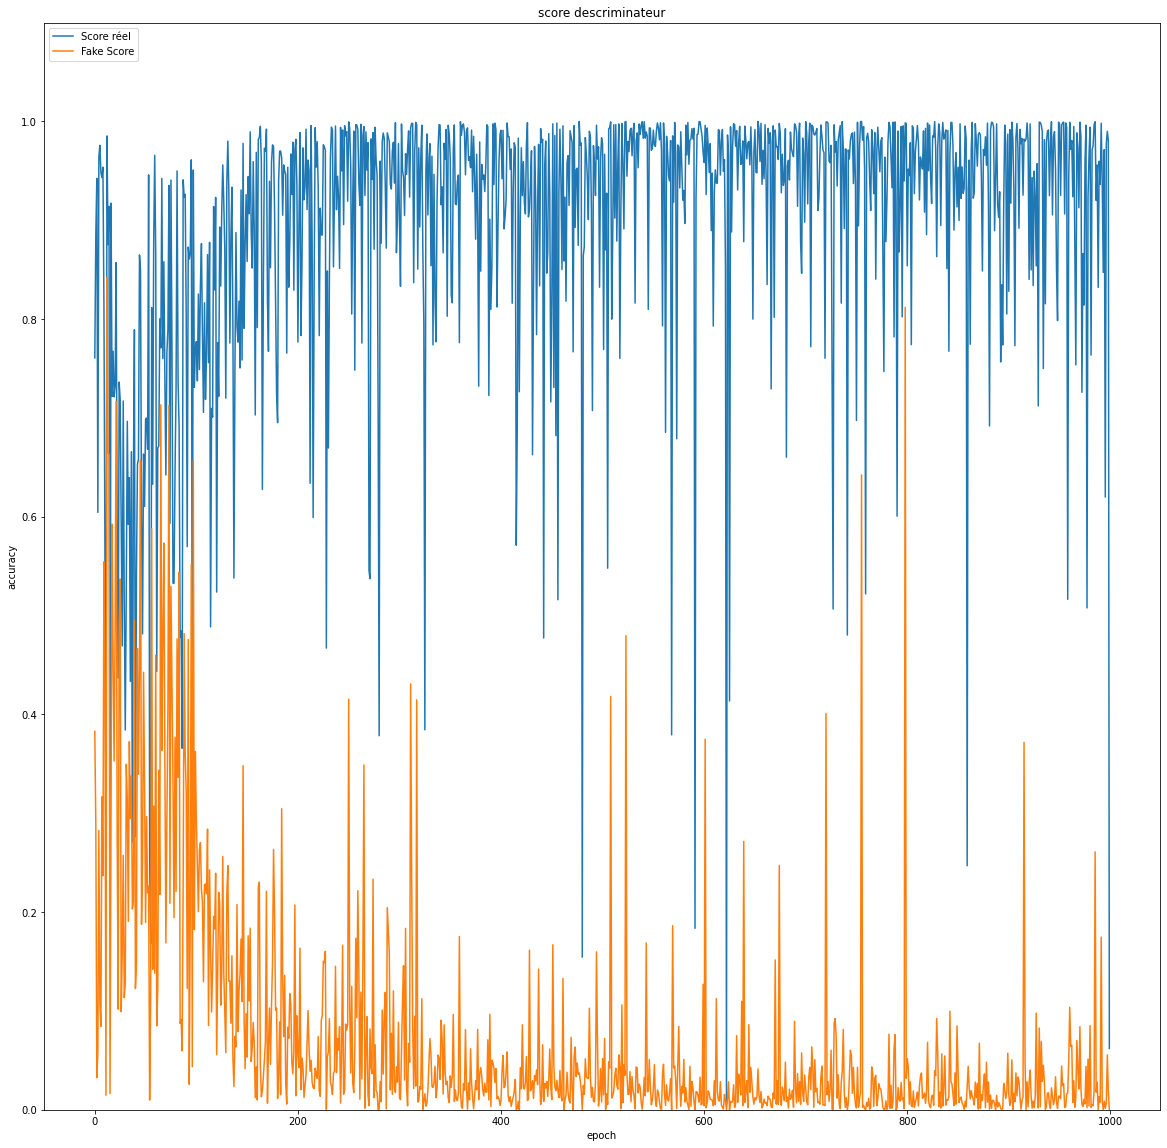

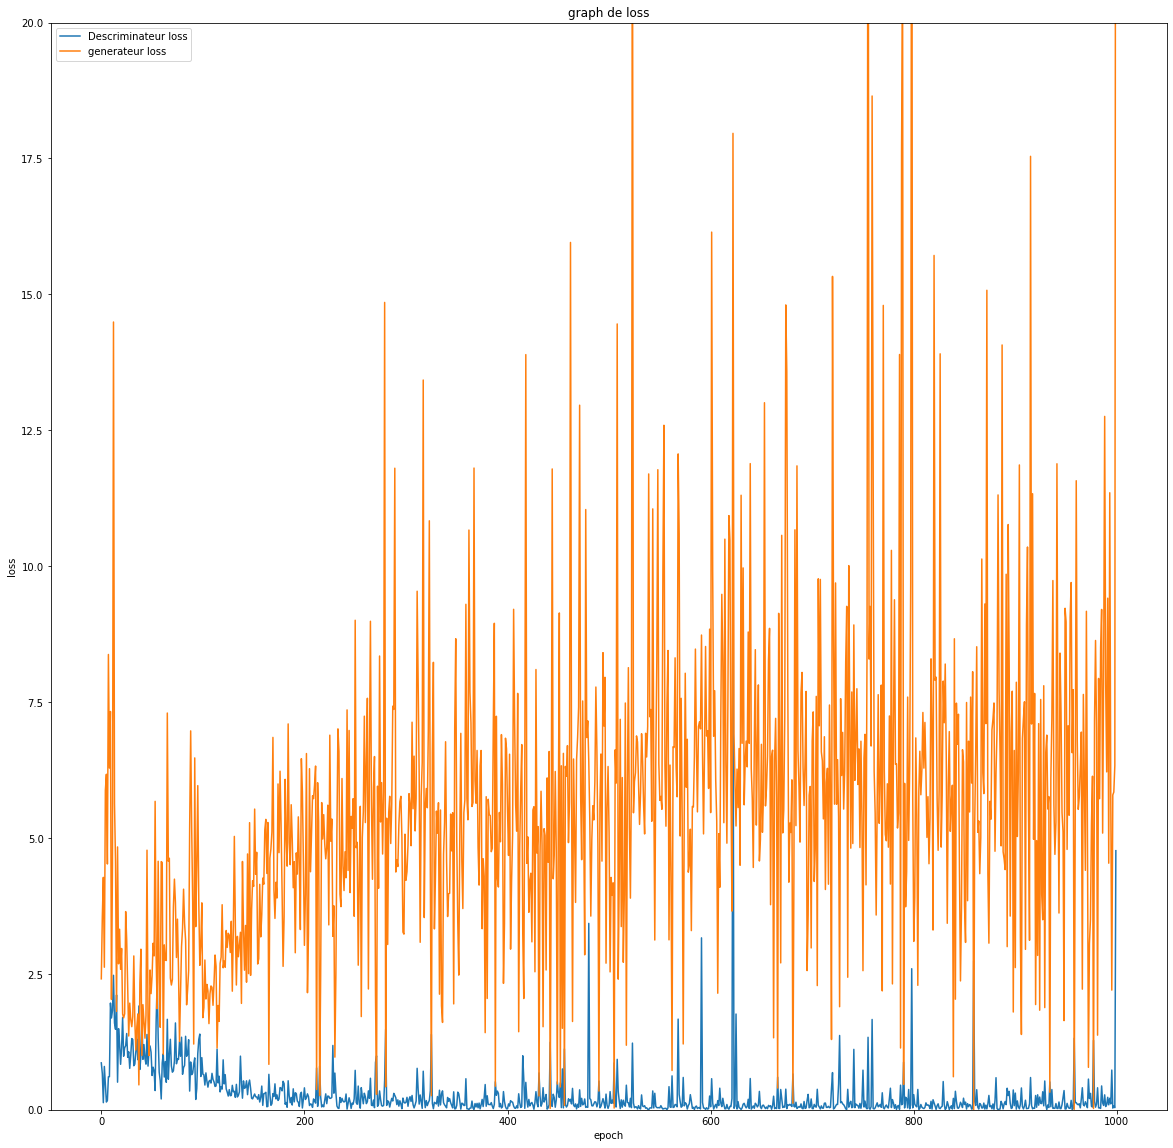

In [46]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.plot(real_scores)
plt.plot(fake_scores)
plt.title('score descriminateur')
plt.ylabel('accuracy')
plt.ylim(0,1.1)
plt.xlabel('epoch')
plt.legend(['Score réel', 'Fake Score'], loc='upper left')

plt.show()

plt.figure(figsize=(20,20))
plt.plot(losses_d)
plt.plot(losses_g)
plt.title('graph de loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Descriminateur loss', 'generateur loss'], loc='upper left')
plt.ylim(0,20)
plt.show()